# OpenBook DeBERTaV3-Large with an updated model

This work is based on the great [work](https://www.kaggle.com/code/nlztrk/openbook-debertav3-large-baseline-single-model) of [nlztrk](https://www.kaggle.com/nlztrk).

I trained a model offline using the dataset I shared [here](https://www.kaggle.com/datasets/mgoksu/llm-science-exam-dataset-w-context). I just added my model to the original notebook. The model is available [here](https://www.kaggle.com/datasets/mgoksu/llm-science-run-context-2).

I also addressed the problem of [CSV Not Found at submission](https://www.kaggle.com/competitions/kaggle-llm-science-exam/discussion/434228) with this notebook by clipping the context like so:

`test_df["prompt"] = test_df["context"].apply(lambda x: x[:1500]) + " #### " +  test_df["prompt"]`

You can probably get more than 1500 without getting an OOM.

In [1]:
from __future__ import annotations
import os
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader

/root/conda_env/chr_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'
sentence_index = read_index("./wiki_index/my_index.bin")
# sentence_index.num_threads = 50
sentence_index = faiss.index_cpu_to_all_gpus(sentence_index)

In [3]:
data = pd.read_csv('./data/recall_val.csv')

In [4]:
data.head()

,id,page_id,prompt_answer,title_text
0,46965,1984610,Why do CROs aim to reduce costs for companies ...,Contract research organization In the life sci...
1,46966,1984610,Which organizations do CROs provide support to...,Contract research organization In the life sci...
2,46967,1984610,What is the responsibility of the CRO in a cli...,Contract research organization In the life sci...
3,46968,1984610,What is the range of CROs in terms of size and...,Contract research organization In the life sci...
4,46969,47448502,What is Swope Soccer Village? A soccer complex...,Swope Soccer Village Swope Soccer Village is a...


In [5]:
BERT_PATH = "sentence-transformers/all-MiniLM-L6-v2"
MODEL_PATH = "./save/recall/recall_epoch100.bin"
PROMPT_LEN = 512
WIKI_LEN = 512
MAX_LEN = 512
BATCH_SIZE = 1024
DEVICE = 'cuda'

In [6]:
import torch.nn as nn
import torch
from transformers import AutoModel, AutoTokenizer
class RecallModel(nn.Module):
    def __init__(self):
        super(RecallModel, self).__init__()
        self.bert_model = AutoModel.from_pretrained(BERT_PATH)
    
    def mask_mean(self, x, mask=None):
        if mask != None:
            mask_x = x * (mask.unsqueeze(-1))
            x_sum = torch.sum(mask_x, dim=1)
            re_x = torch.div(x_sum, torch.sum(mask, dim=1).unsqueeze(-1))
        else:
            x_sum = torch.sum(x, dim=1)
            re_x = torch.div(x_sum, x.size()[1])
        return re_x
    
    def forward(self,input_ids):
        attention_mask = input_ids > 0
        out = self.bert_model(input_ids, attention_mask=attention_mask).last_hidden_state
        x = out[:,0,:]
        return x


In [7]:
model= RecallModel()
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
model.to(DEVICE)

RecallModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=

In [8]:
from tqdm.auto import tqdm
class LLMRecallDataSet(torch.utils.data.Dataset):
    def __init__(self, data):
        self.tokenizer = AutoTokenizer.from_pretrained(BERT_PATH, use_fast=True)
        self.data = data
    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self,index):
        inputs = self.data.loc[index, 'prompt_answer']
        page_id = self.data.loc[index, 'page_id']
        if len(inputs) > 4000:
            inputs = inputs[:4000]
        inputs = self.tokenizer.encode(inputs, add_special_tokens=False)
        if len(inputs) > 510:
            inputs = [101] + inputs[:510] + [102]
        else:
            inputs = [101] + inputs + [102]
        return inputs, page_id
    
    def collate_fn(self, batch):
        def sequence_padding(inputs, length=None, padding=0):
            """
            Numpy函数，将序列padding到同一长度
            """
            if length is None:
                length = max([len(x) for x in inputs])

            pad_width = [(0, 0) for _ in np.shape(inputs[0])]
            outputs = []
            for x in inputs:
                x = x[:length]
                pad_width[0] = (0, length - len(x))
                x = np.pad(x, pad_width, 'constant', constant_values=padding)
                outputs.append(x)

            return np.array(outputs, dtype='int64')
        batch_ids = []
        batch_page_ids = []
        for item in batch:
            ids, page_ids = item
            batch_ids.append(ids)
            batch_page_ids.append(page_ids)
        batch_ids = torch.tensor(sequence_padding(batch_ids), dtype=torch.long)
        
        return batch_ids, batch_page_ids

        
class DataLoaderX(torch.utils.data.DataLoader):
    '''
        replace DataLoader with PrefetchDataLoader
    '''
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())  

    
def get_loader(prompt,batch_size,train_mode=True,num_workers=4):
    ds_df = LLMRecallDataSet(prompt)
    loader = DataLoaderX(ds_df, batch_size=batch_size if train_mode else batch_size//2, shuffle=train_mode, num_workers=num_workers,pin_memory=True,
                                         collate_fn=ds_df.collate_fn, drop_last=train_mode)
    loader.num = len(ds_df)
    return loader

In [9]:
from prefetch_generator import BackgroundGenerator
loader = get_loader(data, 128, False, 4)
model.eval()
embeds = []
with torch.no_grad():
    for batch in tqdm(loader):
        inputs, page_id = batch
        inputs = inputs.to(DEVICE)
        output = model(inputs).cpu().detach().numpy()
        faiss.normalize_L2(output)
        embeds.append(output)

100%|██████████| 36/36 [00:01<00:00, 18.72it/s]


In [10]:
len(embeds)

36

In [11]:
embed = np.concatenate(embeds, axis=0)
np.save('./data/tmp.npy', embed, allow_pickle=True)

In [12]:
embeds = np.load('./data/tmp.npy')

In [13]:
scores, indexs = [], []
subarrays = np.array_split(embeds, 500)
for item in tqdm(subarrays):
    search_score, search_index = sentence_index.search(item, 10)
    scores.append(search_score)
    indexs.append(search_index)

100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


In [14]:
scores[0]

array([[0.8895724 , 0.8807086 , 0.6429883 , 0.62826365, 0.6089584 ,
        0.5876285 , 0.5797845 , 0.573337  , 0.56884503, 0.5636122 ],
       [0.85538644, 0.8298944 , 0.6982315 , 0.65432775, 0.6412564 ,
        0.63575524, 0.61228687, 0.6093652 , 0.60928917, 0.59689015],
       [0.8088464 , 0.80079263, 0.62475806, 0.6111643 , 0.60684216,
        0.5940006 , 0.58520526, 0.5835314 , 0.58288884, 0.57665664],
       [0.7748004 , 0.7527429 , 0.68817943, 0.63961184, 0.6293841 ,
        0.6080365 , 0.5988638 , 0.58108157, 0.5808338 , 0.5734784 ],
       [0.90485585, 0.8850391 , 0.76027477, 0.7579473 , 0.74722147,
        0.7429255 , 0.7281666 , 0.7223827 , 0.72053987, 0.71813965]],
      dtype=float32)

In [15]:
import pickle as pkl
with open('./data/ID2PageID.pkl','rb') as f:
    ID2PageID = pkl.load(f)

In [16]:
page_id = []
for item in indexs:
    for i in range(item.shape[0]):
        tmp = [ID2PageID[j] for j in item[i]]
        page_id.append(tmp)

In [17]:
page_id[0]

['1984610',
 1984610,
 '37696472',
 '1943650',
 '1993537',
 '51287353',
 '39542351',
 '38519122',
 '61204575',
 '27067473']

In [18]:
cnt = 0
sums = 0
for i in range(len(data)):
    x = int(data.loc[i, 'page_id'])
    y = [int(j) for j in page_id[i]]
    # y = int(page_id[i])
    if x in y:
        cnt += 1
    sums += 1
cnt / sums

0.8682136602451839

In [19]:
import json
import pandas as pd
wiki = []
with open('./data/wiki_data.json', 'r',encoding='utf8') as f:
    lines = f.readlines()
    for line in lines:
        wiki.append(json.loads(line))
wiki = pd.DataFrame(wiki)

In [20]:
wiki.drop_duplicates(inplace=True)

In [5]:
wiki = wiki.reset_index(drop=True)

In [6]:
tmp = pd.read_parquet('./wiki_data/wiki_2023_index.parquet')

In [7]:
tmp.head()

,id,title,text,categories,context,file
0,49495844,A & B High Performance Firearms,A & B High Performance Firearms: A & B High Pe...,"[Defunct firearms manufacturers, Defunct manuf...",A & B High Performance Firearms was a competit...,a.parquet
1,3579086,A & C Black,A & C Black: A & C Black is a British book pub...,"[Encyclopædia Britannica, Ornithological publi...",A & C Black is a British book publishing compa...,a.parquet
2,62397582,A & F Harvey Brothers,"A & F Harvey Brothers: A & F Harvey Brothers, ...",[Cotton mills],"A & F Harvey Brothers, first Spinning Cotton M...",a.parquet
3,15547032,A & G Price,A & G Price: A & G Price Limited is an enginee...,"[Locomotive manufacturers of New Zealand, Tham...",A & G Price Limited is an engineering firm and...,a.parquet
4,8021609,A & M Karagheusian,A & M Karagheusian: thumb|right|238px|A portio...,"[1904 establishments in the United States, Arm...",thumb|right|238px|A portion of the Karagheusia...,a.parquet


In [8]:
wiki.head()

,page_id,title,content
0,32439784,Physical mathematics,The subject of physical mathematics is concern...
1,199310,UNIVAC 1004,
2,38183293,DaVinci (software),DaVinci was a development tool used to create ...
3,1997,Algebraic geometry,Algebraic geometry is a branch of mathematics ...
4,10952377,Material-handling equipment,Material handling equipment (MHE) is mechanica...


In [21]:
wiki.columns = ['id', 'title', 'text']

In [22]:
wiki['context'] = wiki.apply(lambda row : ' '.join(str(row[x]) for x in ['title','text']),axis=1)

In [23]:
wiki['file'] = 'extend.parquet'

In [12]:
data = pd.concat([tmp, wiki],axis=0).reset_index(drop=True)

In [13]:
data.to_parquet('./wiki_data/wiki_2023_index.parquet')

In [14]:
data = pd.read_parquet('./wiki_data/a.parquet')

In [15]:
data.head()

,id,title,text,categories
0,49495844,A & B High Performance Firearms,A & B High Performance Firearms was a competit...,"[Defunct firearms manufacturers, Defunct manuf..."
1,3579086,A & C Black,A & C Black is a British book publishing compa...,"[Encyclopædia Britannica, Ornithological publi..."
2,62397582,A & F Harvey Brothers,"A & F Harvey Brothers, first Spinning Cotton M...",[Cotton mills]
3,15547032,A & G Price,A & G Price Limited is an engineering firm and...,"[Locomotive manufacturers of New Zealand, Tham..."
4,8021609,A & M Karagheusian,thumb|right|238px|A portion of the Karagheusia...,"[1904 establishments in the United States, Arm..."


In [16]:
wiki.head()

,id,title,text,context,file
0,32439784,Physical mathematics,The subject of physical mathematics is concern...,Physical mathematics The subject of physical m...,extend.parquet
1,199310,UNIVAC 1004,,UNIVAC 1004,extend.parquet
2,38183293,DaVinci (software),DaVinci was a development tool used to create ...,DaVinci (software) DaVinci was a development t...,extend.parquet
3,1997,Algebraic geometry,Algebraic geometry is a branch of mathematics ...,Algebraic geometry Algebraic geometry is a bra...,extend.parquet
4,10952377,Material-handling equipment,Material handling equipment (MHE) is mechanica...,Material-handling equipment Material handling ...,extend.parquet


In [24]:
wiki = wiki[['id','title', 'context']]

In [26]:
wiki.columns = ['id', 'title', 'text']

In [27]:
wiki['categories'] = ' '

In [28]:
wiki.to_parquet('./wiki_data/extend.parquet')

In [1]:
import pandas as pd
data = pd.read_parquet('./wiki_data/wiki_2023_index.parquet')

In [2]:
data.head()

,id,title,text,categories,context,file
0,49495844,A & B High Performance Firearms,A & B High Performance Firearms: A & B High Pe...,"[Defunct firearms manufacturers, Defunct manuf...",A & B High Performance Firearms was a competit...,a.parquet
1,3579086,A & C Black,A & C Black: A & C Black is a British book pub...,"[Encyclopædia Britannica, Ornithological publi...",A & C Black is a British book publishing compa...,a.parquet
2,62397582,A & F Harvey Brothers,"A & F Harvey Brothers: A & F Harvey Brothers, ...",[Cotton mills],"A & F Harvey Brothers, first Spinning Cotton M...",a.parquet
3,15547032,A & G Price,A & G Price: A & G Price Limited is an enginee...,"[Locomotive manufacturers of New Zealand, Tham...",A & G Price Limited is an engineering firm and...,a.parquet
4,8021609,A & M Karagheusian,A & M Karagheusian: thumb|right|238px|A portio...,"[1904 establishments in the United States, Arm...",thumb|right|238px|A portion of the Karagheusia...,a.parquet


In [2]:
a = pd.read_parquet('./wiki_data/a.parquet')

In [4]:
a.loc[0,'categories']

array(['Defunct firearms manufacturers',
       'Defunct manufacturing companies based in California'],
      dtype=object)

In [5]:
data = pd.read_csv('./data/dataset.csv')

In [1]:
import pandas as pd
import os
df = []
list_dir = os.listdir('./wiki_data')
list_dir = sorted(list_dir)
for path in list_dir:
    if 'wiki_2023_index' in path or 'ipynb' in path or 'my' in path or 'deberta' in path:
        continue
    print(path)
    x = pd.read_parquet(os.path.join('./wiki_data',path))
    x['file'] = path
    df.append(x)
df = pd.concat(df, axis=0).reset_index(drop=True)

a.parquet
b.parquet
c.parquet
d.parquet
e.parquet
f.parquet
g.parquet
h.parquet
i.parquet
j.parquet
k.parquet
l.parquet
m.parquet
n.parquet
number.parquet
o.parquet
other.parquet
p.parquet
q.parquet
r.parquet
s.parquet
t.parquet
u.parquet
v.parquet
w.parquet
x.parquet
y.parquet
z.parquet


In [4]:
df['id'] = df['id'].apply(lambda x : int(x))

In [6]:
df.sort_values(by='id')

,id,title,text,categories,file
135941,39,Albedo,Albedo (; ) is the fraction of sunlight that i...,"[Land surface effects on climate, Climate chan...",a.parquet
126896,303,Alabama,Alabama () is a state in the Southeastern regi...,"[1819 establishments in the United States, Sou...",a.parquet
43021,307,Abraham Lincoln,"Abraham Lincoln ( ; February 12, 1809 – April ...","[1809 births, 1865 deaths, 1865 murders in the...",a.parquet
345266,308,Aristotle,"Aristotle (; Aristotélēs, ; 384–322 BC) was an...","[384 BC births, 322 BC deaths, 4th-century BC ...",a.parquet
233726,309,An American in Paris,An American in Paris is a jazz-influenced orch...,"[1928 compositions, Compositions by George Ger...",a.parquet
...,...,...,...,...,...
4013913,74190908,1988 Argyll and Bute District Council election,Elections to Argyll and Bute Council were held...,[1988 Scottish local elections 1988],number.parquet
4061872,74190935,2001–02 UIC Flames men's basketball team,The 2001–02 UIC Flames men's basketball team r...,[UIC Flames men's basketball seasons Uic Uic U...,number.parquet
2733495,74190944,Karen Anderson (politician),Karen A. Anderson is an American politician in...,"[North Dakota Republicans, North Dakota politi...",k.parquet
6123251,74190979,William B. Davis (politician),"William B. Davis (died June 22, 1935) was an A...","[Year of birth uncertain, 1860s births, 1935 d...",w.parquet


In [15]:
len(a & b)

125233

In [16]:
data.shape

(131049, 4)

In [12]:
import pandas as pd
import pickle as pkl
data = pd.read_parquet('./4w8_bm25_top1000_top20.parquet')

In [13]:
df = pd.read_parquet('./wiki_data/my_index.parquet')

In [14]:
data.head(1)

,id,prompt,A,B,C,D,E,answer,wiki_text,page_id,page_title,stem_label,prompt_answer,index,top1000_to_top20_ids
0,47000,What are some adverse effects associated with ...,Burns and eczema,Cancer and brain disorder,Fetotoxicity and inflammations of peripheral n...,All of the above,None of the above,D,A solvent is a substance that is liquid at the...,73305281,Green solvent,M,What are some adverse effects associated with ...,0,"[2004006, 1486993, 946140, 945569, 5285194, 45..."


In [1]:
import pandas as pd
trn = pd.read_csv('./data/train.csv')
sub = pd.read_csv('./data/submission (6).csv')

In [2]:
answer = trn['answer'].tolist()
pred = sub['prediction'].apply(lambda x : x.split(' ')).tolist()

In [3]:
def calculate_ap(answer_order, correct_answer):
    """
    计算平均准确率
    """
    n = len(answer_order)
    hit = 0
    ap = 0
    for i in range(n):
        if answer_order[i] == correct_answer:
            hit += 1
            ap += hit / (i+1)
    if hit == 0:
        return 0
    else:
        return ap / hit

def calculate_map(answers, correct_answers):
    """
    计算平均准确率均值
    """
    n = len(answers)
    aps = []
    for i in range(n):
        ap = calculate_ap(answers[i], correct_answers[i])
        aps.append(ap)
    return sum(aps) / n

In [4]:
calculate_map(pred, answer)

0.9925

In [1]:
import numpy as np
import random
a = np.array([[random.randint(1, 6800000) for i in range(1000)] for j in range(4200)])

In [3]:
import sys
sys.getsizeof(a)

33600128

In [6]:
np.save('tmp.npy', a,allow_pickle=True)

In [1]:
import pandas as pd
tmp = []
for i in range(10):
    tmp.append(pd.read_csv(f'./tmp/10w_bm25_20_round2_bm25_20_{i}.csv'))
data = pd.concat(tmp, axis=0)

In [2]:
data = data.reset_index(drop=True)

In [5]:
trn1 = pd.read_csv("./data/all_12_with_context2.csv")
trn2 = pd.read_csv('./data/crawl_new_dataset.csv')
trn1['type'] = '6w'
trn2['type'] = '4w8'
trn = pd.concat([trn1,trn2],axis=0).reset_index(drop=True)

In [6]:
trn['context'] = data['context']

In [7]:
trn.to_csv('./data/10w_bm25_20_20_merge.csv')

In [1]:
import pandas as pd
def get_data(context_path, data_path):
    data = pd.read_csv(context_path)
    trt = pd.read_csv(data_path)
    val = None
    if 'crawl' in data_path:
        data = data[data['type'] == '4w8'].reset_index(drop=True)
        tmp = pd.read_csv('./data/recall_val.csv')
        tmp['id'] = tmp['id'].apply(lambda x : int(x))
        val_idx = [x for x in list(tmp['id']) if x < len(data)]
        val = data.loc[val_idx].reset_index(drop=True)
        data = data.drop(val_idx).reset_index(drop=True)
        # val['prompt'] = val['context'].apply(lambda x : x[:1750]) + ' #### ' + val['prompt']
        val['id'] = list(range(len(val)))
        val.index = list(range(len(val)))
    else:
        data = data[data['type'] == '6w'].reset_index(drop=True)
    # data['answer'] = trt['answer']
    # data['concat'] = data.apply(lambda x : str(x['prompt'])+str(x['A'])+str(x['B'])+str(x['C'])+str(x['D'])+str(x['E']),axis=1)
    # data = data.drop_duplicates(subset=['concat'])
    data = data.reset_index(drop=True)
    data.index = list(range(len(data)))
    data['id'] = list(range(len(data)))
    # data['prompt'] = data['context'].apply(lambda x : x[:1750]) + ' #### ' + data['prompt']

    return data, val
train, val = get_data('./data/10w_bm25_20_20_merge.csv', './data/crawl_new_dataset.csv')
data2,_ = get_data('./data/10w_bm25_20_20_merge.csv', './data/all_12_with_context2.csv')
train = pd.concat([train, data2],axis=0).reset_index(drop=True)

In [2]:
train = train[['prompt', 'context','A','B','C','D','E','answer']]
train

,prompt,context,A,B,C,D,E,answer
0,What is physical mathematics?,The subject of physical mathematics is concern...,The study of physically motivated mathematics,The study of mathematical physics,The study of mathematics in physical contexts,The study of mathematical equations,The study of mathematical operations,A
1,Who wrote Physical Arithmetic in 1885?,The details of physical units and their manipu...,Margaret Osler,Alexander Macfarlane,Alhazen,Galileo,Newton,B
2,What did the Mathematical Tripos at Cambridge ...,At Cambridge University the Mathematical Tripo...,Pure mathematics,Applied mathematics,Mixed mathematics,Fluxional calculus,Physical problems,C
3,What mathematical representation is used for m...,The details of physical units and their manipu...,Complex numbers,Quaternions,Linear algebra,Fluxional calculus,Mixed mathematics,C
4,What did the early expressions of kinematics a...,Accordingly these early expressions of kinemat...,Causality,Forces,Mathematical physics,Fluxional calculus,Mixed mathematics,C
...,...,...,...,...,...,...,...,...
107342,"The outer ear, or ear canal, carries sound to ...",The difference in pressure between internal or...,aorta,ear lobe,eardrum,lungs,NaN,C
107343,What sport involves people quickly finding des...,The term is derived from the use of the term f...,mapping,NaN,orienteering,patterning,sticking,C
107344,Almost all earthquakes occur at which place?,Tectonic processes typically occur at plate bo...,mountains,land boundaries,plate boundaries,continental shelf,NaN,C
107345,"Melting glaciers, rising temperatures and drou...",Wildfires in Italy can be a problem. == Impact...,nature's natural cycle,air pollution,global warming,sudden warming,NaN,C


In [3]:
val = val[['prompt', 'context','A','B','C','D','E','answer']]
val

,prompt,context,A,B,C,D,E,answer
0,What are some adverse effects associated with ...,"The traditional organic solvents (acetone, NMP...",Burns and eczema,Cancer and brain disorder,Fetotoxicity and inflammations of peripheral n...,All of the above,None of the above,D
1,What is the goal of the UN sustainability deve...,Solvents represent a major part of the chemica...,To promote the use of petrochemical solvents,To develop green and sustainable solvents,To increase the use of nonpolar solvents,To classify solvents into polar and nonpolar c...,To decrease the use of solvents in various dom...,B
2,What are green solvents derived from?,"It is in this context that so-called green, ec...",Processing of agricultural crops,Petrochemical sources,Regular solvents,Chemical reactions,Water and air pollution,A
3,What makes it difficult to classify green solv...,"It is in this context that so-called green, ec...",Their chemical structure and source can differ,They have adverse effects on health and safety,They are associated with water and air pollution,They are derived from petrochemical sources,They are nonpolar solvents,A
4,What is the significance of the Nora Stone?,It is the most recent dated inscription in the...,It is the oldest Phoenician inscription found ...,It is the only Phoenician inscription found in...,It is the first evidence of Phoenician coloniz...,It is the longest Phoenician inscription ever ...,It is the only known inscription honoring a go...,A
...,...,...,...,...,...,...,...,...
1074,What is Sequenom known for developing?,"It develops enabling molecular technologies, a...",Laboratory genetic tests for infertility,Non-invasive prenatal genetic tests,Diagnostic and testing devices for cancer,Molecular technologies for heart disease,Clinical molecular genetics tests for diabetes,B
1075,Which company acquired Sequenom in 2016?,The acquisition was completed in September 201...,LabCorp,Agena Bioscience,Ariosa,PerkinElmer,Natera,A
1076,Which company did Sequenom sell its bioscience...,In June 2014 the company sold its biosciences ...,Natera,PerkinElmer,Agena Bioscience,LabCorp,Ravgen,C
1077,Which patent battle did Sequenom enter in 2012?,Other companies and universities that are work...,Patent battle with Ariosa,Patent battle with Natera,Patent battle with Illumina,Patent battle with Ravgen,Patent battle with PerkinElmer,A


In [11]:
train.to_csv('./data/train_10w_bm25召回_训LLM用.csv',index=False)
val.to_csv('./data/val_10w_bm25召回_训LLM用.csv',index=False)

In [5]:
train['all'] = train.apply(lambda x : x['prompt']+str(x['A'])+str(x['B'])+str(x['C'])+str(x['D'])+str(x['E']),axis=1)

In [14]:
train['context_l'] = train['context'].apply(lambda x : int(len(x)))
pd.set_option('float_format', '{:f}'.format)
train['context_l'].describe(percentiles=[0.25,0.5,0.75,0.85,0.9,0.95,0.99])

count    107347.000000
mean       5322.204244
std        8972.622649
min         433.000000
25%        3683.000000
50%        4397.000000
75%        5415.000000
85%        6232.000000
90%        7017.400000
95%        8965.000000
99%       22770.320000
max     1837615.000000
Name: context_l, dtype: float64

In [2]:
import pandas as pd
import json
prompt = pd.read_csv('./data/crawl_new_dataset_v2.csv')
print(prompt.shape)
prompt['prompt_answer'] = prompt.apply(lambda row: ' '.join(str(row[field]) for field in ['prompt', 'A', 'B', 'C', 'D', 'E']), axis=1)

(78145, 12)


In [3]:
prompt = prompt.drop_duplicates(subset='prompt_answer').reset_index(drop=True)

In [4]:
prompt.shape

(78008, 13)

In [5]:
s1 = set([int(x) for x in prompt['page_id']])
s2 = set([int(x) for x in df['id']])

In [6]:
mx = 0
prompt['page_id'] = prompt['page_id'].apply(lambda x : int(x))
for item in s1:
    mx = max(mx, prompt[prompt['page_id'] == item].shape[0])
mx

28

In [7]:
s = s1 & s2
print(len(s1))
print(len(s))

14530
13305


In [8]:
prompt['check'] = prompt['page_id'].apply(lambda x : int(x) in s)

In [9]:
prompt = prompt[prompt['check']].reset_index(drop=True)
prompt.shape

(71421, 14)

In [10]:
prompt.head()

,id,prompt,A,B,C,D,E,answer,wiki_text,page_id,page_title,stem_label,prompt_answer,check
0,0,What does the nullity of a graph in graph theo...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The multiplicity of the eigenvalue 0 in the sp...,The number of components of the graph,D,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What does the nullity of a graph in graph theo...,True
1,1,"In the matrix theory of graphs, what is the nu...",n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,A,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,"In the matrix theory of graphs, what is the nu...",True
2,2,Which term is more commonly used to refer to t...,Nullity of the adjacency matrix,Multiplicity of the eigenvalue 0,Cycle rank,Cyclomatic number,Circuit rank,C,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,Which term is more commonly used to refer to t...,True
3,3,What is the formula for calculating the nullit...,n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,B,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What is the formula for calculating the nullit...,True
4,4,What can the nullity of the graph represent in...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The number of components of the graph,The rank of the oriented incidence matrix,E,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What can the nullity of the graph represent in...,True


In [11]:
d = {}
for i in range(len(df)):
    d[int(df.loc[i,'id'])] = i

In [12]:
wiki_text = []
from tqdm.auto import tqdm
for i in tqdm(range(len(prompt))):
    page_id = int(prompt.loc[i,'page_id'])
    idx = d[page_id]
    row = df.loc[idx]
    text = row['title'] + ' '.join(list(row['categories'])) + row['text']
    wiki_text.append(text)

/root/conda_env/chr_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 71421/71421 [00:04<00:00, 14478.58it/s]


In [13]:
prompt['wiki_text'] = wiki_text

In [14]:
prompt = prompt[['prompt', 'A','B','C','D','E','answer','wiki_text','page_id','page_title','stem_label']]
prompt['prompt_answer'] = prompt.apply(lambda x : x['prompt']+str(x['A'])+str(x['B'])+str(x['C'])+str(x['D'])+str(x['E']),axis=1)
prompt['title_text'] = prompt['wiki_text']
prompt = prompt[['prompt', 'A','B','C','D','E','answer','title_text','page_id','page_title','stem_label', 'prompt_answer']]

In [15]:
prompt = prompt.reset_index(drop=True)
prompt.to_parquet('./data/recall_data.parquet')

In [16]:
df = df[df['id'].map(lambda x : int(x) in s)]

In [17]:
df.shape

(13305, 5)

In [18]:
df = df.reset_index(drop=True)

In [19]:
df['title_text'] = df.apply(lambda x : x['title'] + ' '.join(x['categories']) + x['text'],axis=1)
df['prompt_answer'] = 'A'

In [20]:
df.to_parquet('./data/recall_wiki.parquet')

In [21]:
prompt.head()

,prompt,A,B,C,D,E,answer,title_text,page_id,page_title,stem_label,prompt_answer
0,What does the nullity of a graph in graph theo...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The multiplicity of the eigenvalue 0 in the sp...,The number of components of the graph,D,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,What does the nullity of a graph in graph theo...
1,"In the matrix theory of graphs, what is the nu...",n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,A,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,"In the matrix theory of graphs, what is the nu..."
2,Which term is more commonly used to refer to t...,Nullity of the adjacency matrix,Multiplicity of the eigenvalue 0,Cycle rank,Cyclomatic number,Circuit rank,C,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,Which term is more commonly used to refer to t...
3,What is the formula for calculating the nullit...,n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,B,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,What is the formula for calculating the nullit...
4,What can the nullity of the graph represent in...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The number of components of the graph,The rank of the oriented incidence matrix,E,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,What can the nullity of the graph represent in...


In [22]:
df.head()

,id,title,text,categories,file,title_text,prompt_answer
0,60121915,A Brief History of Everyone Who Ever Lived,thumb|right|220px|First US edition cover showi...,"[2016 non-fiction books, Genetics books, Popul...",a.parquet,A Brief History of Everyone Who Ever Lived2016...,A
1,38279,A Commentary on the UNIX Operating System,A Commentary on the UNIX Operating System by J...,"[1976 non-fiction books, Unix books, Computer ...",a.parquet,A Commentary on the UNIX Operating System1976 ...,A
2,693370,A Cyborg Manifesto,"""A Cyborg Manifesto"" is an essay written by Do...","[1985 essays, Criticism of feminism, Gender st...",a.parquet,A Cyborg Manifesto1985 essays Criticism of fem...,A
3,42029817,A Death of Honor,A Death of Honor is a science fiction mystery ...,"[1987 American novels, 1987 science fiction no...",a.parquet,A Death of Honor1987 American novels 1987 scie...,A
4,181880,A Devil's Chaplain,"A Devil's Chaplain: Reflections on Hope, Lies,...","[2003 non- fiction books, Books by Richard Daw...",a.parquet,A Devil's Chaplain2003 non- fiction books Book...,A


In [2]:
import pandas as pd
data = pd.read_csv('./data/crawl_new_dataset_v2.csv')

In [5]:
data['prompt_answer'] = data.apply(lambda row: ' '.join(str(row[field]) for field in ['prompt', 'A', 'B', 'C', 'D', 'E']), axis=1)
data = data.drop_duplicates(subset='prompt_answer').reset_index(drop=True)

In [7]:
data.to_csv('./data/7w8_crawl_dataset.csv')

In [1]:
import pandas as pd
data = pd.read_parquet('./data/recall_data.parquet')

In [2]:
data.head()

,prompt,A,B,C,D,E,answer,title_text,page_id,page_title,stem_label,prompt_answer
0,What does the nullity of a graph in graph theo...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The multiplicity of the eigenvalue 0 in the sp...,The number of components of the graph,D,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,What does the nullity of a graph in graph theo...
1,"In the matrix theory of graphs, what is the nu...",n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,A,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,"In the matrix theory of graphs, what is the nu..."
2,Which term is more commonly used to refer to t...,Nullity of the adjacency matrix,Multiplicity of the eigenvalue 0,Cycle rank,Cyclomatic number,Circuit rank,C,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,Which term is more commonly used to refer to t...
3,What is the formula for calculating the nullit...,n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,B,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,What is the formula for calculating the nullit...
4,What can the nullity of the graph represent in...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The number of components of the graph,The rank of the oriented incidence matrix,E,Nullity (graph theory)Graph theoryThe nullity ...,17458663,Nullity (graph theory),M,What can the nullity of the graph represent in...


In [1]:
import pickle as pkl
import pandas as pd
with open('./tmp/2w_Top1000_blendrecall.pkl', 'rb') as f:
    trn = pkl.load(f)

In [2]:
trn.shape

(20000, 9)

In [3]:
trn.head()

,prompt,answer,A,B,C,D,E,Top1000,page_id
0,Which group has all finite-dimensional represe...,B,Orthogonal group,Symplectic group,Metaplectic group,General linear group,Matrix group,"[5559307, 5479823, 4826133, 3144159, 2383867, ...",55631153
1,How are has-a relationships represented in dat...,A,In an Entity–relationship model,As part of a taxonomic hierarchy,As a containment relation,As a part-of relationship,As an instance-of relationship,"[2116563, 3330145, 4313840, 4313841, 1558556, ...",266684
2,Which bacteria are responsible for the formati...,B,Lactococci,Propionibacteria,Citrate-positive bacteria,Polychroniadou bacteria,Shermanii bacteria,"[5471687, 1638896, 1044691, 943419, 3103230, 3...",29202398
3,Which institutions are involved as consultants...,C,University of the Philippines Diliman and Depa...,Metals Industry Research and Development Cente...,"UP National Center for Transportation Studies,...","Philippine Council for Industry, Energy and Em...",Department of Science and Technology (DOST) an...,"[426131, 5864693, 593131, 95975, 100793, 36425...",58841118
4,What does the birth of a hidden oscillation in...,C,The system has reached a stable equilibrium,The system has reached an unstable equilibrium,The system has crossed a boundary in the param...,The system has reached a limit cycle,The system has reached a hidden attractor,"[2187903, 3029157, 5263036, 4546168, 3112510, ...",33194970


In [2]:
import pandas as pd
prompt = pd.read_csv('./data/7w8_crawl_dataset.csv')
prompt['len'] = prompt['wiki_text'].apply(lambda x : len(x))
prompt['len'].describe()

count    78008.000000
mean      1485.712812
std        607.853134
min        184.000000
25%       1082.000000
50%       1356.000000
75%       1737.000000
max       5472.000000
Name: len, dtype: float64

In [1]:
from __future__ import annotations
import os
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer
from torch.cuda.amp import autocast
import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader

/root/panpingjun/Anaconda/chatglm_ppj/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-10-05 23:13:58,269] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
def process_documents(documents: Iterable[str],
                      document_ids: Iterable,
                      split_sentences: bool = True,
                      filter_len: int = 3,
                      disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Main helper function to process documents from the EMR.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param document_type: String denoting the document type to be processed
    :param document_sections: List of sections for a given document type to process
    :param split_sentences: Flag to determine whether to further split sections into sentences
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """
    
    df = sectionize_documents(documents, document_ids, disable_progress_bar)

    if split_sentences:
        df = sentencize(df.text.values, 
                        df.document_id.values,
                        df.offset.values, 
                        filter_len, 
                        disable_progress_bar)
    return df


def sectionize_documents(documents: Iterable[str],
                         document_ids: Iterable,
                         disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Obtains the sections of the imaging reports and returns only the 
    selected sections (defaults to FINDINGS, IMPRESSION, and ADDENDUM).

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `offset`
    """
    processed_documents = []
    for document_id, document in tqdm(zip(document_ids, documents), total=len(documents), disable=disable_progress_bar):
        row = {}
        text, start, end = (document, 0, len(document))
        row['document_id'] = document_id
        row['text'] = text
        row['offset'] = (start, end)

        processed_documents.append(row)

    _df = pd.DataFrame(processed_documents)
    if _df.shape[0] > 0:
        return _df.sort_values(['document_id', 'offset']).reset_index(drop=True)
    else:
        return _df


def sentencize(documents: Iterable[str],
               document_ids: Iterable,
               offsets: Iterable[tuple[int, int]],
               filter_len: int = 3,
               disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Split a document into sentences. Can be used with `sectionize_documents`
    to further split documents into more manageable pieces. Takes in offsets
    to ensure that after splitting, the sentences can be matched to the
    location in the original documents.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param offsets: Iterable tuple of the start and end indices
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """

    document_sentences = []
    for document, document_id, offset in tqdm(zip(documents, document_ids, offsets), total=len(documents), disable=disable_progress_bar):
        try:
            _, sentence_offsets = bf.text_to_sentences_and_offsets(document)
            for o in sentence_offsets:
                if o[1]-o[0] > filter_len:
                    sentence = document[o[0]:o[1]]
                    abs_offsets = (o[0]+offset[0], o[1]+offset[0])
                    row = {}
                    row['document_id'] = document_id
                    row['text'] = sentence
                    row['offset'] = abs_offsets
                    document_sentences.append(row)
        except:
            continue
    return pd.DataFrame(document_sentences)

In [3]:
trn = pd.read_csv('./data/新8w_with_Top5_recall.csv')
trn['context'] = trn['context'].apply(lambda x : eval(x))
trn

,Unnamed: 0,prompt,A,B,C,D,E,answer,wiki_text,page_title,section,prompt_answer,context
0,0,What is the main focus of Russell Epstein's re...,Neural mechanisms of language processing,Neural mechanisms underlying visual scene perc...,Neural mechanisms of memory formation,Neural mechanisms of motor control,Neural mechanisms of emotional processing,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,What is the main focus of Russell Epstein's re...,[Russell Epstein is a professor of psychology ...
1,1,Which brain areas does Russell Epstein's lab s...,Prefrontal cortex and hippocampus,Parahippocampal and retrosplenial cortices,Motor cortex and cerebellum,Amygdala and thalamus,Visual cortex and auditory cortex,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,Which brain areas does Russell Epstein's lab s...,[Russell Epstein is a professor of psychology ...
2,2,What is the role of the Parahippocampal and re...,Motor control,Emotional processing,Visual scene perception,Spatial navigation,Language processing,D,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,What is the role of the Parahippocampal and re...,[Tactition Monkeys with lesions in the perirhi...
3,3,Where did Epstein receive his undergraduate de...,University of Chicago,Harvard,Stanford,MIT,Columbia,A,Epstein received an undergraduate degree in ph...,Russell Epstein,Education,Where did Epstein receive his undergraduate de...,[Epstein received an undergraduate degree in p...
4,4,Who was E...n of Computer Vision?,Alan Turing,Alan Yuille,Marvin Minsky,Geoffrey Hinton,Yann LeCun,B,Epstein received an undergraduate degree in ph...,Russell Epstein,Education,Who was E...n of Computer Vision? Alan Turing ...,[Epstein received an undergraduate degree in p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80726,80726,Which tournament had the largest prize in Jeop...,Super Jeopardy!,Million Dollar Masters,Tenth Anniversary Tournament,Ultimate Tournament of Champions,Battle of the Decades,D,There have been several special tournaments fe...,Jeopardy!,Tournaments and other events,Which tournament had the largest prize in Jeop...,[There have been several special tournaments f...
80727,80727,"How many matches did the ""Greatest of All Time...",One,Two,Three,Four,Five,D,There have been several special tournaments fe...,Jeopardy!,Tournaments and other events,"How many matches did the ""Greatest of All Time...",[There have been several special tournaments f...
80728,80728,In which year did the Jeopardy! Teen Reunion T...,1998,2008,2009,2010,2011,A,"In November 1998, Jeopardy! traveled to Boston...",Jeopardy!,Tournaments and other events,In which year did the Jeopardy! Teen Reunion T...,"[In November 1998, Jeopardy! traveled to Bosto..."
80729,80729,Which Jeopardy! tournament featured contestant...,Teen Reunion Tournament,Million Dollar Celebrity Invitational,IBM Challenge,All-Star Games,Ultimate Tournament of Champions,B,"In November 1998, Jeopardy! traveled to Boston...",Jeopardy!,Tournaments and other events,Which Jeopardy! tournament featured contestant...,"[In November 1998, Jeopardy! traveled to Bosto..."


In [4]:
trn['context'] = trn['context'].apply(lambda x : ''.join(x))

In [5]:
x = process_documents(trn['context'].tolist(), list(range(len(trn))))

100%|██████████| 80731/80731 [01:42<00:00, 785.52it/s] 


In [8]:
trn.loc[0,'context']

'Russell Epstein is a professor of psychology at the University of Pennsylvania, who studies neural mechanisms underlying visual scene perception, event perception, object recognition, and spatial navigation in humans. His lab studies the role of the Parahippocampal and retrosplenial cortices in determining how people orient themselves relative to their surroundings.His research mostly focuses on the mechanisms underlying neuroplasticity and its influence on the perception of pain.Russell D. Fernald is an American neuroscientist/neuroethologist, currently on the Biology faculty at Stanford University. Fernald is known for his interdisciplinary work based on fieldwork and subsequent neuroethological analysis of an African cichlid fish that he has shown to be a useful and novel model organism. His research spans several domains: 1) in the visual system including the discovery of rod photoreceptor stem cells, circadian renewal of photoreceptor opsins and mechanisms of crystalline lens foc

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
DEVICE = 'cuda'
MAX_LENGTH = 512
BATCH_SIZE = 256
BERT_PATH = "/root/bert_path/sentence-transformer-all-mpnet-base-v2"
# BERT_PATH = "/root/bert_path/sentence-transformers_all-MiniLM-L6-v2"
MODEL_PATH = "./save/recall/recall_epoch100.bin"
WIKI_PATH = "./wiki_data"
wiki_files = os.listdir(WIKI_PATH)

In [4]:
import torch.nn as nn
import torch
from transformers import AutoModel, AutoTokenizer
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class RecallModel(nn.Module):
    def __init__(self):
        super(RecallModel, self).__init__()
        self.bert_model = AutoModel.from_pretrained(BERT_PATH)
        self.mean_pooler = MeanPooling()

    def mask_mean(self, x, mask=None):
        if mask != None:
            mask_x = x * (mask.unsqueeze(-1))
            x_sum = torch.sum(mask_x, dim=1)
            re_x = torch.div(x_sum, torch.sum(mask, dim=1).unsqueeze(-1))
        else:
            x_sum = torch.sum(x, dim=1)
            re_x = torch.div(x_sum, x.size()[1])
        return re_x

    def forward(self, input_ids):
        attention_mask = input_ids > 0
        out = self.bert_model(input_ids, attention_mask=attention_mask).last_hidden_state
        x = self.mean_pooler(out, attention_mask)

        # x = out[:, 0, :]
        return x


In [5]:
trn = pd.read_csv("./data/7w8_crawl_dataset.csv")
trn['prompt_answer'] = trn.apply(lambda row : ' '.join(str(row[x]) for x in ['prompt', 'A', 'B', 'C', 'D', 'E']),axis=1)
# tmp = pd.read_csv('./data/recall_train.csv')
trn

,Unnamed: 0,id,prompt,A,B,C,D,E,answer,wiki_text,page_id,page_title,stem_label,prompt_answer
0,0,0,What does the nullity of a graph in graph theo...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The multiplicity of the eigenvalue 0 in the sp...,The number of components of the graph,D,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What does the nullity of a graph in graph theo...
1,1,1,"In the matrix theory of graphs, what is the nu...",n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,A,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,"In the matrix theory of graphs, what is the nu..."
2,2,2,Which term is more commonly used to refer to t...,Nullity of the adjacency matrix,Multiplicity of the eigenvalue 0,Cycle rank,Cyclomatic number,Circuit rank,C,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,Which term is more commonly used to refer to t...
3,3,3,What is the formula for calculating the nullit...,n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,B,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What is the formula for calculating the nullit...
4,4,4,What can the nullity of the graph represent in...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The number of components of the graph,The rank of the oriented incidence matrix,E,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What can the nullity of the graph represent in...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78003,78003,78140,What is the inscription on the plinth of the a...,Rotary Armillary,Service Above Self,This Armillary was presented to the people of ...,The Rotary Club of Cheam has joined with the R...,December 2000,B,The Millennium Dial Armillary is one of six pi...,43629419,Sutton armillary,M,What is the inscription on the plinth of the a...
78004,78004,78141,How was the Millennium Dial Armillary funded?,By the London Borough of Sutton,By the Rotary Club,By the sponsors listed on the plinth inscription,By the residents of Sutton,By a joint effort between the Rotary Club and ...,C,The Millennium Dial Armillary is one of six pi...,43629419,Sutton armillary,M,How was the Millennium Dial Armillary funded? ...
78005,78005,78142,What is the Ukrainian Physicists' Tournament f...,A competition for secondary school students to...,A competition for university students to solve...,A competition for international physicists to ...,A research project competition for university ...,A creative team competition for university stu...,E,Ukrainian Physicists' Tournament for Universit...,14320529,Ukrainian Physicists' Tournament for Universit...,M,What is the Ukrainian Physicists' Tournament f...
78006,78006,78143,When was the first Open Physicists' Tournament...,2001,2005,2010,2015,2020,A,Ukrainian Physicists' Tournament for Universit...,14320529,Ukrainian Physicists' Tournament for Universit...,M,When was the first Open Physicists' Tournament...


In [6]:
from functools import partial
from torch.utils.data import DataLoader
dataloader_class = partial(DataLoader, pin_memory=True, num_workers=4)
model= RecallModel()
from collections import OrderedDict
def load_param(model_path):
    state_dict = torch.load(model_path, map_location='cpu')
    params = OrderedDict()
    for name, param in state_dict.items():
        name = '.'.join(name.split('.')[1:])
        params[name] = param
    return params
model.load_state_dict(load_param('./save/recall_base/recall0_best.bin'))
# model.load_state_dict(torch.load('./save/recall_new/recall0_best.bin',map_location='cpu'))
model.to(DEVICE)
model = torch.nn.parallel.DataParallel(model)
model.eval()

DataParallel(
  (module): RecallModel(
    (bert_model): MPNetModel(
      (embeddings): MPNetEmbeddings(
        (word_embeddings): Embedding(30527, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): MPNetEncoder(
        (layer): ModuleList(
          (0-11): 12 x MPNetLayer(
            (attention): MPNetAttention(
              (attn): MPNetSelfAttention(
                (q): Linear(in_features=768, out_features=768, bias=True)
                (k): Linear(in_features=768, out_features=768, bias=True)
                (v): Linear(in_features=768, out_features=768, bias=True)
                (o): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    

In [7]:
from tqdm.auto import tqdm
class LLMRecallDataSet(torch.utils.data.Dataset):
    def __init__(self, data, col):
        self.tokenizer = AutoTokenizer.from_pretrained(BERT_PATH, use_fast=True)
        self.data = data
        self.col = col
    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self,index):
        inputs = self.data.loc[index, self.col]
        inputs = self.tokenizer.encode(inputs, add_special_tokens=False)
        if len(inputs) > 510:
            inputs = [101] + inputs[:510] + [102]
        else:
            inputs = [101] + inputs + [102]
        return inputs
    
    def collate_fn(self, batch):
        def sequence_padding(inputs, length=None, padding=0):
            """
            Numpy函数，将序列padding到同一长度
            """
            if length is None:
                length = max([len(x) for x in inputs])

            pad_width = [(0, 0) for _ in np.shape(inputs[0])]
            outputs = []
            for x in inputs:
                x = x[:length]
                pad_width[0] = (0, length - len(x))
                x = np.pad(x, pad_width, 'constant', constant_values=padding)
                outputs.append(x)

            return np.array(outputs, dtype='int64')
        batch_ids = torch.tensor(sequence_padding(batch), dtype=torch.long)
        
        return batch_ids

        
class DataLoaderX(torch.utils.data.DataLoader):
    '''
        replace DataLoader with PrefetchDataLoader
    '''
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())  

    
def get_loader(prompt,col,batch_size,train_mode=True,num_workers=4):
    ds_df = LLMRecallDataSet(prompt,col)
    # loader = DataLoaderX(ds_df, batch_size=batch_size if train_mode else batch_size//2, shuffle=train_mode, num_workers=num_workers,pin_memory=True,
    #                                      collate_fn=ds_df.collate_fn, drop_last=train_mode)
    loader = dataloader_class(ds_df, batch_size=batch_size, shuffle=False,collate_fn=ds_df.collate_fn)
    loader.num = len(ds_df)
    return loader

In [8]:
from prefetch_generator import BackgroundGenerator
loader = get_loader(trn, 'prompt_answer',50, False)
prompt_embeddings = []
with torch.no_grad():
    for batch in tqdm(loader):
        batch = batch.to(DEVICE)
        with autocast():
            output = model(batch).cpu().detach().numpy()
        faiss.normalize_L2(output)
        prompt_embeddings.append(output)
prompt_embeddings = np.concatenate(prompt_embeddings, axis=0)

100%|██████████| 1561/1561 [00:38<00:00, 40.79it/s]


In [9]:
sentence_index = read_index("./wiki_index/blend_base_index_part1.bin")
scores1, indexs1 = [], []
subarrays = np.array_split(prompt_embeddings, 20)
for item in tqdm(subarrays):
    search_score, search_index = sentence_index.search(item, 1000)
    scores1.append(search_score)
    indexs1.append(search_index)
del sentence_index
_ = gc.collect()
libc.malloc_trim(0)
sentence_index = read_index("./wiki_index/blend_base_index_part2.bin")
scores2, indexs2 = [], []
for item in tqdm(subarrays):
    search_score, search_index = sentence_index.search(item, 1000)
    scores2.append(search_score)
    indexs2.append(search_index)
del sentence_index
_ = gc.collect()
libc.malloc_trim(0)

100%|██████████| 20/20 [02:47<00:00,  8.37s/it]


1

In [10]:
scores1 = np.concatenate(scores1, axis=0)
scores2 = np.concatenate(scores2, axis=0)
indexs1 = np.concatenate(indexs1, axis=0)
indexs2 = np.concatenate(indexs2, axis=0)

In [11]:
search_index = []
for i in tqdm(range(len(trn))):
    s1, i1 = scores1[i], indexs1[i]
    s2, i2 = scores2[i], indexs2[i]
    tmp = []
    for s, i in zip(s1, i1):
        tmp.append([s, i])
    for s, i in zip(s2, i2):
        tmp.append([s, i + 3099999])
    tmp = sorted(tmp, key=lambda x : x[0],reverse=True)
    tmp = tmp[:1000]
    search_index.append([item[1] for item in tmp])

100%|██████████| 78008/78008 [02:05<00:00, 620.78it/s] 


In [12]:
len(search_index)

78008

In [13]:
trn['Top1000'] = search_index

In [14]:
trn.head()

,Unnamed: 0,id,prompt,A,B,C,D,E,answer,wiki_text,page_id,page_title,stem_label,prompt_answer,Top1000
0,0,0,What does the nullity of a graph in graph theo...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The multiplicity of the eigenvalue 0 in the sp...,The number of components of the graph,D,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What does the nullity of a graph in graph theo...,"[3876952, 4778094, 74006, 3554666, 3876892, 38..."
1,1,1,"In the matrix theory of graphs, what is the nu...",n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,A,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,"In the matrix theory of graphs, what is the nu...","[3876952, 4778094, 74006, 3554666, 74004, 1993..."
2,2,2,Which term is more commonly used to refer to t...,Nullity of the adjacency matrix,Multiplicity of the eigenvalue 0,Cycle rank,Cyclomatic number,Circuit rank,C,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,Which term is more commonly used to refer to t...,"[3876952, 4778094, 1015508, 592872, 610861, 74..."
3,3,3,What is the formula for calculating the nullit...,n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,B,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What is the formula for calculating the nullit...,"[3876952, 4778094, 1993693, 3418262, 3418253, ..."
4,4,4,What can the nullity of the graph represent in...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The number of components of the graph,The rank of the oriented incidence matrix,E,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What can the nullity of the graph represent in...,"[3876952, 4778094, 5317850, 3418253, 74006, 34..."


In [15]:
trn = trn[['prompt','A','B','C','D','E','answer','page_id','page_title','Top1000']]

In [19]:
import pickle as pkl
with open('./tmp/7w_Top1000.pkl','rb') as f:
    data = pkl.load(f)

In [21]:
data.shape

(78008, 10)

In [1]:
from datasets import load_from_disk
data1 = load_from_disk("./small_wiki_data_base")
data1 = data1.to_pandas()
data1.to_parquet('./small_wiki_data_base/data.parquet')

In [3]:
data1.head()

,id,title,text,url,wiki_id,views,paragraph_id,langs
0,5443,Google Translate,Google Translate is a multilingual neural mach...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,0,97
1,5444,Google Translate,Launched in April 2006 as a statistical machin...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,1,97
2,5445,Google Translate,Google Translate is a web-based free-to-user t...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,2,97
3,5446,Google Translate,"Originally, Google Translate was released as a...",https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,3,97
4,5447,Google Translate,"In January 2010, Google introduced an Android ...",https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,4,97


In [2]:
data2 = load_from_disk('./small_wiki_data')

In [3]:
len(set(data1['title']) & set(data2['title']))

276558

In [4]:
data1 = data1.to_pandas()
data2 = data2.to_pandas()

In [13]:
data1['title'].unique().shape

(277046,)

In [14]:
data2['title'].unique().shape

(276559,)

In [10]:
print(len(s))
print(len(t))
print(len(s & t))

277046
6286775
264053


In [11]:
data = data.to_pandas()

In [5]:
import pandas as pd
trn = pd.read_csv('./data/7w8_crawl_dataset.csv')
trn.head()

,Unnamed: 0,id,prompt,A,B,C,D,E,answer,wiki_text,page_id,page_title,stem_label,prompt_answer
0,0,0,What does the nullity of a graph in graph theo...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The multiplicity of the eigenvalue 0 in the sp...,The number of components of the graph,D,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What does the nullity of a graph in graph theo...
1,1,1,"In the matrix theory of graphs, what is the nu...",n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,A,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,"In the matrix theory of graphs, what is the nu..."
2,2,2,Which term is more commonly used to refer to t...,Nullity of the adjacency matrix,Multiplicity of the eigenvalue 0,Cycle rank,Cyclomatic number,Circuit rank,C,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,Which term is more commonly used to refer to t...
3,3,3,What is the formula for calculating the nullit...,n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,B,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What is the formula for calculating the nullit...
4,4,4,What can the nullity of the graph represent in...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The number of components of the graph,The rank of the oriented incidence matrix,E,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What can the nullity of the graph represent in...


In [6]:
s = set(data1['wiki_id'].tolist())

In [7]:
trn[trn['page_id'].apply(lambda x : x in s)].reset_index(drop=True).to_csv('./tmp/4w.csv')

In [6]:
data['title'].unique().shape

(276559,)

In [7]:
data.loc[0, 'text']

'Russell Epstein is a professor of psychology at the University of Pennsylvania, who studies neural mechanisms underlying visual scene perception, event perception, object recognition, and spatial navigation in humans. His lab studies the role of the Parahippocampal and retrosplenial cortices in determining how people orient themselves relative to their surroundings.'

In [8]:
data.loc[1,'text']

'Epstein received an undergraduate degree in physics at the University of Chicago and a Ph.D. in computer vision with Alan Yuille at Harvard.'

In [9]:
data.to_parquet('./small_wiki_data/data.parquet')

In [2]:
import pickle as pkl
from tqdm.auto import tqdm
cnt = 0
for i in range(60):
    print(i)
    with open(f'./tmp/token/corpus_{i}.pkl','rb') as f:
        tmp = pkl.load(f)
        for item in tqdm(tmp):
            with open(f'./tmp/split_token/{cnt}.pkl','wb') as f:
                pkl.dump(item, f)
            cnt += 1

0


  0%|          | 0/104779 [00:00<?, ?it/s]

1


  0%|          | 0/104779 [00:00<?, ?it/s]

2


  0%|          | 0/104779 [00:00<?, ?it/s]

3


  0%|          | 0/104779 [00:00<?, ?it/s]

4


  0%|          | 0/104779 [00:00<?, ?it/s]

5


  0%|          | 0/104779 [00:00<?, ?it/s]

6


  0%|          | 0/104779 [00:00<?, ?it/s]

7


  0%|          | 0/104779 [00:00<?, ?it/s]

8


  0%|          | 0/104779 [00:00<?, ?it/s]

9


  0%|          | 0/104779 [00:00<?, ?it/s]

10


  0%|          | 0/104779 [00:00<?, ?it/s]

11


  0%|          | 0/104779 [00:00<?, ?it/s]

12


  0%|          | 0/104779 [00:00<?, ?it/s]

13


  0%|          | 0/104779 [00:00<?, ?it/s]

14


  0%|          | 0/104779 [00:00<?, ?it/s]

15


  0%|          | 0/104779 [00:00<?, ?it/s]

16


  0%|          | 0/104779 [00:00<?, ?it/s]

17


  0%|          | 0/104779 [00:00<?, ?it/s]

18


  0%|          | 0/104779 [00:00<?, ?it/s]

19


  0%|          | 0/104779 [00:00<?, ?it/s]

20


  0%|          | 0/104779 [00:00<?, ?it/s]

21


  0%|          | 0/104779 [00:00<?, ?it/s]

22


  0%|          | 0/104779 [00:00<?, ?it/s]

23


  0%|          | 0/104779 [00:00<?, ?it/s]

24


  0%|          | 0/104779 [00:00<?, ?it/s]

25


  0%|          | 0/104779 [00:00<?, ?it/s]

26


  0%|          | 0/104779 [00:00<?, ?it/s]

27


  0%|          | 0/104779 [00:00<?, ?it/s]

28


  0%|          | 0/104779 [00:00<?, ?it/s]

29


  0%|          | 0/104779 [00:00<?, ?it/s]

30


  0%|          | 0/104779 [00:00<?, ?it/s]

31


  0%|          | 0/104779 [00:00<?, ?it/s]

32


  0%|          | 0/104779 [00:00<?, ?it/s]

33


  0%|          | 0/104779 [00:00<?, ?it/s]

34


  0%|          | 0/104779 [00:00<?, ?it/s]

35


  0%|          | 0/104779 [00:00<?, ?it/s]

36


  0%|          | 0/104779 [00:00<?, ?it/s]

37


  0%|          | 0/104779 [00:00<?, ?it/s]

38


  0%|          | 0/104779 [00:00<?, ?it/s]

39


  0%|          | 0/104779 [00:00<?, ?it/s]

40


  0%|          | 0/104779 [00:00<?, ?it/s]

41


  0%|          | 0/104779 [00:00<?, ?it/s]

42


  0%|          | 0/104779 [00:00<?, ?it/s]

43


  0%|          | 0/104779 [00:00<?, ?it/s]

44


  0%|          | 0/104779 [00:00<?, ?it/s]

45


  0%|          | 0/104779 [00:00<?, ?it/s]

46


  0%|          | 0/104779 [00:00<?, ?it/s]

47


  0%|          | 0/104779 [00:00<?, ?it/s]

48


  0%|          | 0/104779 [00:00<?, ?it/s]

49


  0%|          | 0/104779 [00:00<?, ?it/s]

50


  0%|          | 0/104779 [00:00<?, ?it/s]

51


  0%|          | 0/104779 [00:00<?, ?it/s]

52


  0%|          | 0/104779 [00:00<?, ?it/s]

53


  0%|          | 0/104779 [00:00<?, ?it/s]

54


  0%|          | 0/104779 [00:00<?, ?it/s]

55


  0%|          | 0/104779 [00:00<?, ?it/s]

56


  0%|          | 0/104779 [00:00<?, ?it/s]

57


  0%|          | 0/104779 [00:00<?, ?it/s]

58


  0%|          | 0/104779 [00:00<?, ?it/s]

59


  0%|          | 0/104814 [00:00<?, ?it/s]

In [10]:
import os
import shutil
from tqdm.auto import tqdm
# 设置目标文件夹路径
target_folder = "./tmp/split_token"

# 循环处理每个文件
for i in tqdm(range(0, 7000000, 1000)):
    # 创建文件夹名
    folder_name = str(i)
    
    # 创建文件夹路径
    folder_path = os.path.join(target_folder, folder_name)
    
    # 检查文件夹是否已存在，如果不存在则创建
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    
    # 移动文件到对应文件夹
    for j in range(0, 1000):
        file_name = str(i + j) + ".pkl"
        # 检查文件是否存在，如果存在则移动
        if os.path.exists('./tmp/split_token/'+file_name):
            os.remove('./tmp/split_token/'+file_name)


  0%|          | 0/7000 [00:00<?, ?it/s]

In [ ]:
os.listdir('./tmp/split_token')

In [2]:
import os
os.path.exists('./tmp/split_token/1.pkl')

True

In [11]:
import pandas as pd
data = pd.read_parquet('./data/6w_bm25_blendrecall_top1000_top30.parquet')

In [12]:
data

,prompt,context,A,B,C,D,E,answer,source,prompt_answer,index,top1000_to_top30_ids
0,"In relation to Eunice Fay McKenzie's career, w...","Eunice Fay McKenzie (February 19, 1918 – April...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B,1,"In relation to Eunice Fay McKenzie's career, w...",0,"[1672980, 2434200, 2225748, 5539441, 577051, 2..."
1,How does Modified Newtonian Dynamics (MOND) im...,The presence of a clustered thick disk-like co...,MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E,1,How does Modified Newtonian Dynamics (MOND) im...,1,"[1830805, 1228442, 748639, 3573843, 5559316, 1..."
2,Which of the following statements accurately d...,Woody Hartman is a retired American soccer goa...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B,1,Which of the following statements accurately d...,2,"[4789707, 1302988, 4788998, 1063857, 4789382, ..."
3,What is the significance of the Museum of the ...,The Museum of the Occupation of Latvia () is a...,The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C,1,What is the significance of the Museum of the ...,3,"[3669879, 3669577, 3669963, 1597785, 3669701, ..."
4,What was the previous name of the Christian Sc...,It was named the Evangelical School for the De...,The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D,1,What was the previous name of the Christian Sc...,4,"[988551, 1060434, 797210, 3145550, 4374104, 58..."
...,...,...,...,...,...,...,...,...,...,...,...,...
60342,"The outer ear, or ear canal, carries sound to ...","The ear canal (external acoustic meatus, exter...",aorta,ear lobe,eardrum,lungs,None,C,12,"The outer ear, or ear canal, carries sound to ...",60342,"[3523205, 1444030, 4515173, 3523206, 4352391, ..."
60343,What sport involves people quickly finding des...,Orienteering sports in which route choice is a...,mapping,None,orienteering,patterning,sticking,C,12,What sport involves people quickly finding des...,60343,"[5796820, 4335770, 213023, 2159791, 5796865, 4..."
60344,Almost all earthquakes occur at which place?,This subduction zone led to the formation of t...,mountains,land boundaries,plate boundaries,continental shelf,None,C,12,Almost all earthquakes occur at which place? m...,60344,"[1446828, 2370289, 5799482, 5959871, 1104837, ..."
60345,"Melting glaciers, rising temperatures and drou...",Impacts include changes in regional rainfall p...,nature's natural cycle,air pollution,global warming,sudden warming,None,C,12,"Melting glaciers, rising temperatures and drou...",60345,"[1486966, 5599463, 1040075, 2241538, 1040050, ..."


In [13]:
data.loc[0,'top1000_to_top30_ids']

array([1672980, 2434200, 2225748, 5539441,  577051, 2010697, 5715597,
       3378362,  178539,  964534, 1861806,  581455,  545616, 2666128,
       3715512, 5685985, 2504459, 1596930, 5179016, 3281852,  279114,
       2749560, 2434201,  853475, 3368242, 3030670,  818061, 2665753,
       1982176, 5030326])

In [14]:
data.loc[0,'top1000_to_top30_ids'].shape

(30,)

In [1]:
import pickle as pkl
with open('./tmp/part0.pkl','rb') as f:
    data1 = pkl.load(f)
with open('./tmp/part2.pkl', 'rb') as f:
    data2 = pkl.load(f)

In [2]:
data1

,prompt,context,A,B,C,D,E,answer,source,type,Unnamed: 0,id,wiki_text,page_id,page_title,stem_label,prompt_answer,Top30
0,"In relation to Eunice Fay McKenzie's career, w...","Eunice Fay McKenzie (February 19, 1918 – April...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B,1.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,"In relation to Eunice Fay McKenzie's career, w...","[1672980, 1468708, 2225748, 577051, 2434200, 2..."
1,How does Modified Newtonian Dynamics (MOND) im...,The presence of a clustered thick disk-like co...,MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E,1.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,How does Modified Newtonian Dynamics (MOND) im...,"[1830805, 1228442, 748639, 3573843, 1167741, 5..."
2,Which of the following statements accurately d...,Woody Hartman is a retired American soccer goa...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B,1.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,Which of the following statements accurately d...,"[4789707, 5419231, 5768533, 4788998, 2598481, ..."
3,What is the significance of the Museum of the ...,The Museum of the Occupation of Latvia () is a...,The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C,1.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,What is the significance of the Museum of the ...,"[3669879, 2948076, 2948089, 1162504, 2528645, ..."
4,What was the previous name of the Christian Sc...,It was named the Evangelical School for the De...,The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D,1.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,What was the previous name of the Christian Sc...,"[988551, 797210, 3145550, 4374104, 5573348, 21..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46114,What is the name for a bundle of axons within ...,A bundle of axons make a nerve tract in the ce...,fascicle,tract,nerve root,epineurium,epineurium,A,9.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,What is the name for a bundle of axons within ...,"[3773832, 4516232, 1549417, 1564870, 3773939, ..."
46115,Which cranial nerve does not control functions...,Cranial nerves relay information between the b...,olfactory,trochlear,glossopharyngeal,vagus,olfactory,D,9.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,Which cranial nerve does not control functions...,"[1137128, 5499836, 691430, 1945341, 4296270, 8..."
46116,Which of these structures is not under direct ...,"The PNS consists of nerves and ganglia, which ...",trigeminal ganglion,gastric plexus,sympathetic chain ganglia,cervical plexus,sympathetic chain ganglia,B,9.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,Which of these structures is not under direct ...,"[5478341, 5446064, 4695197, 3240221, 2347772, ..."
46117,Which of the followings are possible remedies ...,UCC Insurance is utilized for transactions des...,FLSA.,WCA.,OSHA.,FMLA.,WCA.,C,9.0,6w,NaN,NaN,NaN,NaN,NaN,NaN,Which of the followings are possible remedies ...,"[5128315, 4270159, 4515044, 5896029, 5886031, ..."


In [3]:
data2

,prompt,context,A,B,C,D,E,answer,source,type,Unnamed: 0,id,wiki_text,page_id,page_title,stem_label,prompt_answer,Top30
0,What is the highest point in Ivory Coast?,NaN,Mount Richard-Molard,Mount Guinea,Mount Burkina,Mount Ghana,Mount Liberia,A,NaN,7w8,31890.0,31902.0,The wildlife of Ivory Coast consists of the fl...,10946504.0,Wildlife of Ivory Coast,S,What is the highest point in Ivory Coast? Moun...,"[3640222, 3119595, 3306909, 1870383, 5137660, ..."
1,How many species of mammal have been recorded ...,NaN,100 species,200 species,300 species,400 species,500 species,D,NaN,7w8,31891.0,31903.0,The wildlife of Ivory Coast consists of the fl...,10946504.0,Wildlife of Ivory Coast,S,How many species of mammal have been recorded ...,"[6116122, 6116094, 6116184, 2937908, 4382336, ..."
2,Which country borders Ivory Coast to the east?,NaN,Liberia,Guinea,Mali,Burkina Faso,Ghana,E,NaN,7w8,31892.0,31904.0,The wildlife of Ivory Coast consists of the fl...,10946504.0,Wildlife of Ivory Coast,S,Which country borders Ivory Coast to the east?...,"[1870349, 754236, 2411045, 754233, 754238, 420..."
3,What is the dominant habitat type in Ivory Coast?,NaN,Tropical rainforest,Gallery forests,Savanna,Desert,Mountainous region,C,NaN,7w8,31893.0,31905.0,The wildlife of Ivory Coast consists of the fl...,10946504.0,Wildlife of Ivory Coast,S,What is the dominant habitat type in Ivory Coa...,"[6116122, 6116152, 1451645, 3112924, 6116184, ..."
4,How many species of bird have been recorded in...,NaN,100 species,200 species,300 species,400 species,500 species,B,NaN,7w8,31894.0,31906.0,The wildlife of Ivory Coast consists of the fl...,10946504.0,Wildlife of Ivory Coast,S,How many species of bird have been recorded in...,"[6116122, 4208758, 6116094, 6116202, 3102800, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46113,What is the inscription on the plinth of the a...,NaN,Rotary Armillary,Service Above Self,This Armillary was presented to the people of ...,The Rotary Club of Cheam has joined with the R...,December 2000,B,NaN,7w8,78003.0,78140.0,The Millennium Dial Armillary is one of six pi...,43629419.0,Sutton armillary,M,What is the inscription on the plinth of the a...,"[5456608, 3188648, 3660099, 942381, 5339602, 6..."
46114,How was the Millennium Dial Armillary funded?,NaN,By the London Borough of Sutton,By the Rotary Club,By the sponsors listed on the plinth inscription,By the residents of Sutton,By a joint effort between the Rotary Club and ...,C,NaN,7w8,78004.0,78141.0,The Millennium Dial Armillary is one of six pi...,43629419.0,Sutton armillary,M,How was the Millennium Dial Armillary funded? ...,"[5456608, 3188648, 1320182, 5456661, 6043588, ..."
46115,What is the Ukrainian Physicists' Tournament f...,NaN,A competition for secondary school students to...,A competition for university students to solve...,A competition for international physicists to ...,A research project competition for university ...,A creative team competition for university stu...,E,NaN,7w8,78005.0,78142.0,Ukrainian Physicists' Tournament for Universit...,14320529.0,Ukrainian Physicists' Tournament for Universit...,M,What is the Ukrainian Physicists' Tournament f...,"[5873747, 2365219, 4566202, 5313060, 4403394, ..."
46116,When was the first Open Physicists' Tournament...,NaN,2001,2005,2010,2015,2020,A,NaN,7w8,78006.0,78143.0,Ukrainian Physicists' Tournament for Universit...,14320529.0,Ukrainian Physicists' Tournament for Universit...,M,When was the first Open Physicists' Tournament...,"[5873747, 4566202, 5894257, 1618919, 4403394, ..."


In [2]:
import pandas as pd
data = pd.read_pickle('./data/12w_base_recall_base_sentence.pkl')

In [3]:
data = data[['prompt', 'context', 'A', 'B', 'C', 'D', 'E', 'answer']]

,prompt,context,A,B,C,D,E,answer,source,prompt_answer,index,top1000_to_top30_ids,Unnamed: 0,id,wiki_text,page_id,page_title,stem_label,answer_all,prompt_answer_stem
0,"In relation to Eunice Fay McKenzie's career, w...","Eunice Fay McKenzie (February 19, 1918 – April...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B,1.0,"In relation to Eunice Fay McKenzie's career, w...",0,"[1672980, 2434200, 2225748, 5539441, 577051, 2...",NaN,0,NaN,NaN,NaN,NaN,McKenzie showcased her singing talents in nume...,"In relation to Eunice Fay McKenzie's career, w..."
1,How does Modified Newtonian Dynamics (MOND) im...,"The results are consistent with MOND, and plac...",MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E,1.0,How does Modified Newtonian Dynamics (MOND) im...,1,"[1830805, 1228442, 748639, 3573843, 5559316, 1...",NaN,1,NaN,NaN,NaN,NaN,MOND is a theory that increases the discrepanc...,How does Modified Newtonian Dynamics (MOND) im...
2,Which of the following statements accurately d...,Ray Montgomerie (born 17 April 1961) is a Scot...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B,1.0,Which of the following statements accurately d...,2,"[4789707, 1302988, 4788998, 1063857, 4789382, ...",NaN,2,NaN,NaN,NaN,NaN,Ray Montgomerie is a former footballer who pla...,Which of the following statements accurately d...
3,What is the significance of the Museum of the ...,The Museum of the Occupation of Latvia () is a...,The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C,1.0,What is the significance of the Museum of the ...,3,"[3669879, 3669577, 3669963, 1597785, 3669701, ...",NaN,3,NaN,NaN,NaN,NaN,The Museum of the Occupation of Latvia is a me...,What is the significance of the Museum of the ...
4,What was the previous name of the Christian Sc...,The Christian School and Chapel for the Deaf (...,The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D,1.0,What was the previous name of the Christian Sc...,4,"[988551, 1060434, 797210, 3145550, 4374104, 58...",NaN,4,NaN,NaN,NaN,NaN,The Christian School for the Deaf (CSD) The Ch...,What was the previous name of the Christian Sc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138351,What is the inscription on the plinth of the a...,The armillary also had to be removed temporari...,Rotary Armillary,Service Above Self,This Armillary was presented to the people of ...,The Rotary Club of Cheam has joined with the R...,December 2000,B,NaN,What is the inscription on the plinth of the a...,38999,"[5456608, 3188648, 5456506, 5456632, 858659, 3...",78003.0,138351,The Millennium Dial Armillary is one of six pi...,43629419.0,Sutton armillary,M,Rotary Armillary Service Above Self This Armil...,What is the inscription on the plinth of the a...
138352,How was the Millennium Dial Armillary funded?,The Millennium Dial Armillary is one of six pi...,By the London Borough of Sutton,By the Rotary Club,By the sponsors listed on the plinth inscription,By the residents of Sutton,By a joint effort between the Rotary Club and ...,C,NaN,How

In [5]:
data[data['page_id'].isna()].reset_index(drop=True)

,prompt,context,A,B,C,D,E,answer,source,prompt_answer,index,top1000_to_top30_ids,Unnamed: 0,id,wiki_text,page_id,page_title,stem_label,answer_all,prompt_answer_stem
0,"In relation to Eunice Fay McKenzie's career, w...","Eunice Fay McKenzie (February 19, 1918 – April...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B,1.0,"In relation to Eunice Fay McKenzie's career, w...",0,"[1672980, 2434200, 2225748, 5539441, 577051, 2...",NaN,0,NaN,NaN,NaN,NaN,McKenzie showcased her singing talents in nume...,"In relation to Eunice Fay McKenzie's career, w..."
1,How does Modified Newtonian Dynamics (MOND) im...,"The results are consistent with MOND, and plac...",MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E,1.0,How does Modified Newtonian Dynamics (MOND) im...,1,"[1830805, 1228442, 748639, 3573843, 5559316, 1...",NaN,1,NaN,NaN,NaN,NaN,MOND is a theory that increases the discrepanc...,How does Modified Newtonian Dynamics (MOND) im...
2,Which of the following statements accurately d...,Ray Montgomerie (born 17 April 1961) is a Scot...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B,1.0,Which of the following statements accurately d...,2,"[4789707, 1302988, 4788998, 1063857, 4789382, ...",NaN,2,NaN,NaN,NaN,NaN,Ray Montgomerie is a former footballer who pla...,Which of the following statements accurately d...
3,What is the significance of the Museum of the ...,The Museum of the Occupation of Latvia () is a...,The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C,1.0,What is the significance of the Museum of the ...,3,"[3669879, 3669577, 3669963, 1597785, 3669701, ...",NaN,3,NaN,NaN,NaN,NaN,The Museum of the Occupation of Latvia is a me...,What is the significance of the Museum of the ...
4,What was the previous name of the Christian Sc...,The Christian School and Chapel for the Deaf (...,The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D,1.0,What was the previous name of the Christian Sc...,4,"[988551, 1060434, 797210, 3145550, 4374104, 58...",NaN,4,NaN,NaN,NaN,NaN,The Christian School for the Deaf (CSD) The Ch...,What was the previous name of the Christian Sc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60342,"The outer ear, or ear canal, carries sound to ...",The outer ear is supplied by a number of arter...,aorta,ear lobe,eardrum,lungs,None,C,12.0,"The outer ear, or ear canal, carries sound to ...",60342,"[3523205, 1444030, 4515173, 3523206, 4352391, ...",NaN,60342,NaN,NaN,NaN,NaN,aorta ear lobe eardrum lungs None,"The outer ear, or ear canal, carries sound to ..."
60343,What sport involves people quickly finding des...,"The locations of the controls, the start and t...",mapping,None,orienteering,patterning,sticking,C,12.0,What sport involves people quickly finding des...,60343,"[5796820, 4335770, 213023, 2159791, 5796865, 4...",NaN,60343,NaN,NaN,NaN,NaN,mapping None orienteering patterning sticking,What sport involves people quickly finding des...
60344,Almost all earthquakes occur at which place?,Relatively few earthquakes occur in intrap

In [27]:
import pickle as pkl
import math
from tqdm.auto import tqdm
from six import iteritems
from six.moves import range
import numpy as np
import heapq
from collections.abc import Iterable


PARAM_K1 = 1.5
PARAM_B = 0.75
EPSILON = 0.25


class mybm25(object):
    """Implementation of Best Matching 25 ranking function.

    Attributes
    ----------
    corpus_size : int
        Size of corpus (number of documents).
    avgdl : float
        Average length of document in `corpus`.
    doc_freqs : list of dicts of int
        Dictionary with terms frequencies for each document in `corpus`. Words used as keys and frequencies as values.
    idf : dict
        Dictionary with inversed documents frequencies for whole `corpus`. Words used as keys and frequencies as values.
    doc_len : list of int
        List of document lengths.
    """

    def __init__(self, corpus):
        """
        Parameters
        ----------
        corpus : list of list of str
            Given corpus.

        """
        self.corpus_size = len(corpus)
        self.avgdl = 0
        self.doc_freqs = []
        self.idf = {}
        self.doc_len = {}
        self._initialize(corpus)
        self.get_score_by_reversed_index_all_documents(corpus)

    def _initialize(self, corpus):
        """Calculates frequencies of terms in documents and in corpus. Also computes inverse document frequencies."""
        nd = {}  # word -> number of documents with word
        num_doc = 0
        for j, document in tqdm(enumerate(corpus),total=len(corpus)):
            self.doc_len[j] = len(document)
            num_doc += len(document)

            frequencies = {}
            for word in document:
                if word not in frequencies:
                    frequencies[word] = 0
                frequencies[word] += 1
            self.doc_freqs.append(frequencies)

            for word, freq in iteritems(frequencies):
                if word not in nd:
                    nd[word] = 0
                nd[word] += 1

        self.avgdl = float(num_doc) / self.corpus_size
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        self.nd = nd
        for word, freq in tqdm(iteritems(nd), total=len(nd)):
            idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = float(idf_sum) / len(self.idf)

        eps = EPSILON * self.average_idf
        for word in tqdm(negative_idfs,total=len(negative_idfs)):
            self.idf[word] = eps

    def similarity_bm25(self, document_a, document_b):
        """Computes BM25 score of given `document A` in relation to given `document B` .

        Parameters
        ----------
        document_a : list of str
            Document to be scored.
        document_b : list of str
            Document to be scored.
        Returns
        -------
        float
            BM25 score.

        """
        assert isinstance(document_a,Iterable),'document a is not iterable'
        assert isinstance(document_b,Iterable),'document b is not iterable'
        score = 0
        doc_freqs = {}
        for word in document_b:
            if word not in doc_freqs:
                doc_freqs[word] = 0
            doc_freqs[word] += 1
        freq = 1
        default_idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
        for word in document_a:
            if word not in doc_freqs:
                continue
            score += (self.idf.get(word,default_idf) * doc_freqs[word] * (PARAM_K1 + 1)
                      / (doc_freqs[word] + PARAM_K1 * (1 - PARAM_B + PARAM_B * len(document_b) / self.avgdl)))
        return score


    def get_score_by_reversed_index_all_documents(self, corpus):
        """
        Build reverted index for documents like {word:{index:grades}}
        """
        document_score = {}
        for index, document in tqdm(enumerate(corpus),total=len(corpus)):
            q_id =  index
            doc_freqs = self.doc_freqs[index]
            for word in document:
                if word not in doc_freqs:
                    continue
                score = (self.idf[word] * doc_freqs[word] * (PARAM_K1 + 1)
                          / (doc_freqs[word] + PARAM_K1 * (1 - PARAM_B + PARAM_B * self.doc_len[index] / self.avgdl)))
                if word not in document_score:
                    document_score[word] = {q_id: round(score, 2)}
                else:
                    document_score[word].update({q_id: round(score, 2)})
        self.document_score = document_score

    def top_k_sentence(self,document,k=1):
        """
        document: Iterable, to be retrieved
        Returns
        -------
        float
            List of [(nearest sentence,index,score)].
        """
        assert isinstance(document,Iterable),'document is not iterable'
        score_overall = {}
        for word in document:
            if word not in self.document_score:
                continue
            for key, value in self.document_score[word].items():
                if key not in score_overall:
                  # print(score_overall)
                    score_overall[key] = value
                else:
                    score_overall[key] += value
        k_keys_sorted = heapq.nlargest(k, score_overall,key=score_overall.__getitem__)
        return [(item,score_overall.get(item,None)) for item in k_keys_sorted]

In [2]:
with open('./tmp/bm25.pkl','rb') as f:
    bm25 = pkl.load(f)

In [4]:
bm25

In [5]:
len(bm25.document_score)

1240069

In [1]:
import pandas as pd
data = pd.read_csv('./data/7w8_crawl_dataset.csv')


In [2]:
data.head()

,Unnamed: 0,id,prompt,A,B,C,D,E,answer,wiki_text,page_id,page_title,stem_label,prompt_answer
0,0,0,What does the nullity of a graph in graph theo...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The multiplicity of the eigenvalue 0 in the sp...,The number of components of the graph,D,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What does the nullity of a graph in graph theo...
1,1,1,"In the matrix theory of graphs, what is the nu...",n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,A,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,"In the matrix theory of graphs, what is the nu..."
2,2,2,Which term is more commonly used to refer to t...,Nullity of the adjacency matrix,Multiplicity of the eigenvalue 0,Cycle rank,Cyclomatic number,Circuit rank,C,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,Which term is more commonly used to refer to t...
3,3,3,What is the formula for calculating the nullit...,n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,B,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What is the formula for calculating the nullit...
4,4,4,What can the nullity of the graph represent in...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The number of components of the graph,The rank of the oriented incidence matrix,E,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What can the nullity of the graph represent in...


In [ ]:
from datasets import load_from_disk
data1 = load_from_disk('./small_wiki_data')
data2 = load_from_disk('./small_wiki_data_base')

In [1]:
import json
data = []
with open('./data/new_ft_data_8w.json','r') as f:
    lines = f.readlines()
    for line in lines:
        data.append(json.loads(line))

In [2]:
data[0]

{'question': "What is the main focus of Russell Epstein's research?",
 'option_1': 'Neural mechanisms of language processing',
 'option_2': 'Neural mechanisms underlying visual scene perception',
 'option_3': 'Neural mechanisms of memory formation',
 'option_4': 'Neural mechanisms of motor control',
 'option_5': 'Neural mechanisms of emotional processing',
 'answer': 'option_2',
 'wiki_text': 'Russell Epstein is a professor of psychology at the University of Pennsylvania, who studies neural mechanisms underlying visual scene perception, event perception, object recognition, and spatial navigation in humans. His lab studies the role of the Parahippocampal and retrosplenial cortices in determining how people orient themselves relative to their surroundings.',
 'page_title': 'Russell Epstein',
 'section': 'Russell Epstein'}

In [3]:
d = {'option_1':'A', 'option_2':'B', 'option_3':'C', 'option_4':'D','option_5':'E'}
new = []
for i in range(len(data)):
    if data[i]['answer'] not in ['option_1','option_2','option_3','option_4','option_5']:
        continue
    data[i]['answer'] = d[data[i]['answer']]
    new.append(data[i])

In [4]:
len(data)

82084

In [5]:
len(new)

80973

In [6]:
new[0]

{'question': "What is the main focus of Russell Epstein's research?",
 'option_1': 'Neural mechanisms of language processing',
 'option_2': 'Neural mechanisms underlying visual scene perception',
 'option_3': 'Neural mechanisms of memory formation',
 'option_4': 'Neural mechanisms of motor control',
 'option_5': 'Neural mechanisms of emotional processing',
 'answer': 'B',
 'wiki_text': 'Russell Epstein is a professor of psychology at the University of Pennsylvania, who studies neural mechanisms underlying visual scene perception, event perception, object recognition, and spatial navigation in humans. His lab studies the role of the Parahippocampal and retrosplenial cortices in determining how people orient themselves relative to their surroundings.',
 'page_title': 'Russell Epstein',
 'section': 'Russell Epstein'}

In [7]:
import pandas as pd
new = pd.DataFrame(new)
new = new.drop(new[new['option_4'].isna() | new['option_1'].isna() | new['option_2'].isna() | new['option_3'].isna() | new['option_5'].isna() | new['question'].isna() | new['answer'].isna()].index).reset_index(drop=True)

In [8]:
new.shape

(80731, 85)

In [9]:
new = new[['question', 'option_1', 'option_2', 'option_3', 'option_4', 'option_5', 'answer', 'wiki_text', 'page_title', 'section']]

In [10]:
new.columns = ['prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'wiki_text', 'page_title', 'section']

In [11]:
new.to_csv('./data/新8w数据.csv')

In [44]:
data = pd.read_csv('./tmp/4w.csv')

In [46]:
data = data[['prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'wiki_text', 'page_title', 'page_id']]

In [47]:
tmp = pd.concat([new, data],axis=0).reset_index(drop=True)

In [48]:
tmp

,prompt,A,B,C,D,E,answer,wiki_text,page_title,section,page_id
0,What is the main focus of Russell Epstein's re...,Neural mechanisms of language processing,Neural mechanisms underlying visual scene perc...,Neural mechanisms of memory formation,Neural mechanisms of motor control,Neural mechanisms of emotional processing,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN
1,Which brain areas does Russell Epstein's lab s...,Prefrontal cortex and hippocampus,Parahippocampal and retrosplenial cortices,Motor cortex and cerebellum,Amygdala and thalamus,Visual cortex and auditory cortex,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN
2,What is the role of the Parahippocampal and re...,Motor control,Emotional processing,Visual scene perception,Spatial navigation,Language processing,D,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN
3,Where did Epstein receive his undergraduate de...,University of Chicago,Harvard,Stanford,MIT,Columbia,A,Epstein received an undergraduate degree in ph...,Russell Epstein,Education,NaN
4,Who was E...n of Computer Vision?,Alan Turing,Alan Yuille,Marvin Minsky,Geoffrey Hinton,Yann LeCun,B,Epstein received an undergraduate degree in ph...,Russell Epstein,Education,NaN
...,...,...,...,...,...,...,...,...,...,...,...
52289,Who defined magic polygons as n-sided regular ...,Victoria Jakicic and Rachelle Bouchat,Danniel Dias Augusto and Josimar da Silva,Both Victoria Jakicic and Rachelle Bouchat and...,Neither Victoria Jakicic and Rachelle Bouchat ...,There is no information about it,A,A magic polygon is a polygonal magic graph wit...,Magic polygon,NaN,53160480.0
52290,What is the definition of a degenerated magic ...,A set of vertices of concentric n-gon and a ce...,A magic polygon with a magic constant equal to 0,A magic polygon with only one node,A polygon that is not a regular polygon,A magic polygon with only one side,A,A magic polygon is a polygonal magic graph wit...,Magic polygon,NaN,53160480.0
52291,What is the purpose of a gas meter prover?,To measure the volume of gas passed through a ...,To repair gas meters in facilities,To monitor the accuracy of a gas meter,To determine the meter factor,To verify the industry standards for gas meters,C,A gas meter prover is a device to verify the a...,Gas meter prover,NaN,13741562.0
52292,What is a bell prover?,A device used to repair gas meters,A reference standard used in gas meter proving,An industry standard for gas meters,A device used to seal gas meters,A device used to measure the volume of air,B,A gas meter prover is a device to verify the a...,Gas meter prover,NaN,13741562.0


In [49]:
tmp.to_csv('./data/5w2_data.csv',index=False)

In [55]:
data = pd.read_csv('./data/5w2_with_Top5_recall.csv')

/tmp/ipykernel_368545/1958854108.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/5w2_with_Top5_recall.csv')


In [63]:
data = data[data['page_id'].isna()].reset_index(drop=True)

In [64]:
cnt = 0
for i in range(len(data)):
    wiki = data.loc[i,'wiki_text']
    top1 = data.loc[i,'Top1']
    top2 = data.loc[i,'Top2']
    top3 = data.loc[i,'Top3']
    top4 = data.loc[i,'Top4']
    top5 = data.loc[i,'Top5']
    if (wiki in top1) or (top1 in wiki):
        cnt += 1
    elif (wiki in top2) or (top2 in wiki):
        cnt += 1
    elif (wiki in top3) or (top3 in wiki):
        cnt += 1
    elif (wiki in top4) or (top4 in wiki):
        cnt += 1
    elif (wiki in top5) or (top5 in wiki):
        cnt += 1
cnt / len(data)

0.8906900014345144

In [56]:
data.loc[0,'wiki_text']

'Russell Epstein is a professor of psychology at the University of Pennsylvania, who studies neural mechanisms underlying visual scene perception, event perception, object recognition, and spatial navigation in humans. His lab studies the role of the Parahippocampal and retrosplenial cortices in determining how people orient themselves relative to their surroundings.'

In [57]:
data.loc[0,'Top1']

'Russell Epstein is a professor of psychology at the University of Pennsylvania, who studies neural mechanisms underlying visual scene perception, event perception, object recognition, and spatial navigation in humans. His lab studies the role of the Parahippocampal and retrosplenial cortices in determining how people orient themselves relative to their surroundings.'

In [65]:
data.shape

(6971, 17)

In [66]:
data['context'] = data['Top1'] + data['Top2'] + data['Top3'] + data['Top4'] + data['Top5']

In [67]:
data['le'] = data['context'].apply(lambda x : len(x))

In [68]:
data['le'].describe()

count     6971.000000
mean      3269.519438
std       1515.047201
min        556.000000
25%       2274.000000
50%       2929.000000
75%       3890.000000
max      24205.000000
Name: le, dtype: float64

In [69]:
df = pd.read_parquet('./small_wiki_data/data.parquet')

In [74]:
token = []
from transformers import AutoTokenizer
from tqdm.auto import tqdm
tokenizer = AutoTokenizer.from_pretrained('/root/bert_path/sentence-transformer-all-mpnet-base-v2')
for text in tqdm(df['text']):
    t = tokenizer.encode(text, add_special_tokens=False)
    token.append(t)

  0%|          | 0/2101279 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


In [75]:
le = [len(item) for item in token]

In [89]:
cut_le = [i for i in le if i < 512]
len(cut_le)

2062756

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd 
from datasets import load_dataset, load_from_disk
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import LongformerTokenizer, LongformerForMultipleChoice
from transformers import AutoTokenizer, AutoModelForMultipleChoice
import transformers
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import unicodedata

import gc
import os

[2023-10-06 21:33:09,087] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
stop_words = [
    'each', 'you', 'the', 'use', 'used',
    'where', 'themselves', 'nor', "it's", 'how', "don't", 'just', 'your',
    'about', 'himself', 'with', "weren't", 'hers', "wouldn't", 'more', 'its', 'were',
    'his', 'their', 'then', 'been', 'myself', 're', 'not',
    'ours', 'will', 'needn', 'which', 'here', 'hadn', 'it', 'our', 'there', 'than',
    'most', "couldn't", 'both', 'some', 'for', 'up', 'couldn', "that'll",
    "she's", 'over', 'this', 'now', 'until', 'these', 'few', 'haven',
    'of', 'wouldn', 'into', 'too', 'to', 'very', 'shan', 'before', 'the', 'they',
    'between', "doesn't", 'are', 'was', 'out', 'we', 'me',
    'after', 'has', "isn't", 'have', 'such', 'should', 'yourselves', 'or', 'during', 'herself',
    'doing', 'in', "shouldn't", "won't", 'when', 'do', 'through', 'she',
    'having', 'him', "haven't", 'against', 'itself', 'that',
    'did', 'theirs', 'can', 'those',
    'own', 'so', 'and', 'who', "you've", 'yourself', 'her', 'he', 'only',
    'what', 'ourselves', 'again', 'had', "you'd", 'is', 'other',
    'why', 'while', 'from', 'them', 'if', 'above', 'does', 'whom',
    'yours', 'but', 'being', "wasn't", 'be'
]

In [3]:
df = pd.read_parquet('./small_wiki_data/data.parquet')

In [4]:
trn = pd.read_csv("./tmp/recall_val.csv")
trn['prompt_answer'] = trn.apply(lambda row : ' '.join(str(row[x]) for x in ['prompt', 'A', 'B', 'C', 'D', 'E']),axis=1)
df['context'] = df['title'] + ' ' + df['section'] + ' ' + df['text']

In [5]:
vectorizer1 = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words)
vectorizer1.fit(trn['prompt_answer'].tolist())
vocab_df_valid = vectorizer1.get_feature_names_out()

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                             stop_words=stop_words,
                             vocabulary=vocab_df_valid)
vectorizer.fit(df['text'].tolist()[:800000])

TfidfVectorizer(ngram_range=(1, 2),
                stop_words=['each', 'you', 'the', 'use', 'used', 'where',
                            'themselves', 'nor', "it's", 'how', "don't", 'just',
                            'your', 'about', 'himself', 'with', "weren't",
                            'hers', "wouldn't", 'more', 'its', 'were', 'his',
                            'their', 'then', 'been', 'myself', 're', 'not',
                            'ours', ...],
                token_pattern='(?u)\\b[\\w/.-]+\\b|!|/|\\?|\\"|\\\'',
                vocabulary=array(['!', '! !', '! "', ..., 'ℵ0 exactly', 'ℵ1', 'ℵ1 exactly'],
      dtype=object))

In [7]:
prompt_embed = vectorizer.transform(trn['prompt_answer'].tolist())

In [8]:
prompt_embed.shape

(2692, 56405)

In [9]:
db_embed = vectorizer.transform(df['text'].tolist())

In [10]:
db_embed.shape

(2101279, 56405)

In [11]:
score = prompt_embed * db_embed.T

In [12]:
score = score.toarray()

In [13]:
index = score.argpartition(-1000, axis=1)[:, -1000:]

In [14]:
index.shape

(2692, 1000)

In [15]:
cnt = 0
for i in tqdm(range(len(trn))):
    wiki = trn.loc[i,'wiki_text']
    a = 0
    for j in index[i]:
        text = df.loc[j, 'text']
        if (wiki in text) or (text in wiki):
            a = 1
    cnt += a
cnt / len(trn)

100%|██████████| 2692/2692 [00:22<00:00, 121.58it/s]


0.9791976225854383

In [16]:
trn.loc[0,'wiki_text']

'Ambient Orb was introduced by Ambient Devices in 2002. The device was a glowing sphere that displayed data through changes in color. Ambient Orb was customizable in terms of content and its subsequent visual representation. For instance, when the device was set to monitor a stock market index (e.g. NASDAQ), the Orb glowed green/red to represent the upward/downward price movements; alternatively, it turned amber when the index is unchanged. Nabeel Hyatt stated that the device was marketed as an interior design item with additional functionality.'

In [19]:
# context = []
# for i in range(len(trn)):
#     t = ""
#     for j in index[i]:
#         t += df.loc[j, 'text']
#     context.append(t)
context = []
for i in range(len(trn)):
    t = []
    for j in ids[i]:
        t.append(df.loc[j, 'text'])
    context.append(t)

In [20]:
trn['context'] = context

In [22]:
trn.to_parquet('./tmp/recall_val_tfidf_top1000_top10.parquet')

In [17]:
token = []
for i in range(30):
    import pickle as pkl
    with open(f'./tmp/token/{i}.pkl', 'rb') as f:
        token.extend(pkl.load(f))

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
def word_process(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    return words
stop_words = set(stopwords.words('english'))


def query_process(q):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    keywords = [word for word in words if word not in stop_words]
    return " ".join(keywords)

def recall_doc(q, bm25):
    q = word_process(q)
    res_ids = [item[1] for item in bm25.top_k_sentence(q,  k=10)]
    return res_ids

from fastbm25 import fastbm25
ids = []
for i in tqdm(range(len(trn))):
    idxs = list(index[i])
    token_corpus = [token[item] for item in idxs]
    bm25 = fastbm25(token_corpus)
    res_ids = recall_doc(trn.loc[i, 'prompt_answer'], bm25)
    tmp = [idxs[item] for item in res_ids]
    ids.append(tmp)

100%|██████████| 2692/2692 [08:20<00:00,  5.37it/s]


In [58]:
context = []
for i in range(len(trn)):
    t = ""
    for j in ids[i]:
        t += df.loc[j, 'text']
    context.append(t)
trn['context'] = context

In [59]:
test_df = trn.copy()

In [61]:
test_df.index = list(range(len(test_df)))
test_df['id'] = list(range(len(test_df)))
test_df["prompt"] = test_df["context"].apply(lambda x: x[:1750]) + " #### " +  test_df["prompt"]
from collections import OrderedDict
def load_param(model, path):
    state_dict = torch.load(path,map_location='cpu')
    params = OrderedDict()
    for name, param in state_dict.items():
        if 'module.' in name:
            name = name[7:]
            params[name] = param
    model.load_state_dict(params, strict=False)
    return model
model_dir = "./pretrain_models/microsoft_deberta_large"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model = load_param(model, './save/10w_ema_bm25_20_20.bin')
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at ./pretrain_models/microsoft_deberta_large and are newly initialized: ['classifier.weight', 'pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [62]:
import os
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer
from torch.cuda.amp import autocast
import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader

In [63]:
# We'll create a dictionary to convert option names (A, B, C, D, E) into indices and back again
options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
    # The AutoModelForMultipleChoice class expects a set of question/answer pairs
    # so we'll copy our question 5 times before tokenizing
    first_sentence = [example['prompt']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(str(example[option]))
    # Our tokenizer will turn our text into token IDs BERT can understand
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True)
    # tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

In [64]:
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        # label_name = "label" if 'label' in features[0].keys() else 'labels'
        # labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [65]:
tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E']].drop(columns=['id'])).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E'])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [66]:
test_predictions = []
from torch.cuda.amp import autocast
for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        with autocast():
            outputs = model(**batch)
    test_predictions.append(outputs.logits.cpu().detach())

test_predictions = torch.cat(test_predictions)

predictions_as_ids = np.argsort(-test_predictions, 1)

predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_as_ids]
# predictions_as_answer_letters[:3]

predictions_as_string = test_df['prediction'] = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]

100%|██████████| 2692/2692 [04:27<00:00, 10.06it/s]


In [67]:
pred = test_df['prediction'].apply(lambda x : x.split(' ')).tolist()
answer = test_df['answer'].tolist()
def calculate_ap(answer_order, correct_answer):
    """
    计算平均准确率
    """
    n = len(answer_order)
    hit = 0
    ap = 0
    for i in range(n):
        if answer_order[i] == correct_answer:
            hit += 1
            ap += hit / (i+1)
    if hit == 0:
        return 0
    else:
        return ap / hit

def calculate_map(answers, correct_answers):
    """
    计算平均准确率均值
    """
    n = len(answers)
    aps = []
    for i in range(n):
        ap = calculate_ap(answers[i], correct_answers[i])
        aps.append(ap)
    return sum(aps) / n
calculate_map(pred, answer)

0.868499257057949

# 获取15w8的揉合数据

In [1]:
import pandas as pd
data = pd.read_parquet('./small_wiki_data_base/data.parquet')
data.head()

,id,title,text,url,wiki_id,views,paragraph_id,langs
0,5443,Google Translate,Google Translate is a multilingual neural mach...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,0,97
1,5444,Google Translate,Launched in April 2006 as a statistical machin...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,1,97
2,5445,Google Translate,Google Translate is a web-based free-to-user t...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,2,97
3,5446,Google Translate,"Originally, Google Translate was released as a...",https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,3,97
4,5447,Google Translate,"In January 2010, Google introduced an Android ...",https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,4,97


In [1]:
import pandas as pd
data1 = pd.read_csv('./data/10w_bm25_20_20_merge.csv')
data1['prompt_answer'] = data1.apply(lambda row: ' '.join(str(row[field]) for field in ['prompt', 'A', 'B', 'C', 'D', 'E']), axis=1)

In [2]:
data4w8 = data1[data1['type'] == '4w8'].reset_index(drop=True)
data6w = data1[data1['type'] == '6w'].reset_index(drop=True)

In [3]:
data2 = pd.read_csv('./data/5w2_with_Top5_recall.csv')
data2['prompt_answer'] = data2.apply(lambda row: ' '.join(str(row[field]) for field in ['prompt', 'A', 'B', 'C', 'D', 'E']), axis=1)

/tmp/ipykernel_187680/76861076.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv('./data/5w2_with_Top5_recall.csv')


In [4]:
set1 = set(data4w8['prompt_answer'].tolist())
set2 = set(data2['prompt_answer'].tolist())
len(set1 & set2)

27750

In [5]:
data4w8 = data4w8[~data4w8['prompt_answer'].isin(set1 & set2)].reset_index(drop=True)

In [6]:
data4w8.shape

(20322, 13)

In [7]:
data2 = data2[data2['section'].isna()].reset_index(drop=True)
data2['context'] = data2.apply(lambda row: ' '.join(str(row[field]) for field in ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']), axis=1)

In [8]:
data2.drop('Top1',inplace=True,axis=1)
data2.drop('Top2',inplace=True,axis=1)
data2.drop('Top3',inplace=True,axis=1)
data2.drop('Top4',inplace=True,axis=1)
data2.drop('Top5',inplace=True,axis=1)

In [9]:
data2.shape

(45323, 13)

In [10]:
data3 = pd.read_csv('./data/新8w_with_Top5_recall.csv')
data3['type'] = '新微调数据'

In [11]:
data4w8['type'] = '4w8旧格式'
data6w['type'] = '6w'
data2['type'] = '4w5新格式'

In [12]:
data = pd.concat([data4w8, data6w, data2, data3],axis=0).reset_index(drop=True)

In [13]:
data['prompt_answer'] = data.apply(lambda row: ' '.join(str(row[field]) for field in ['prompt', 'A', 'B', 'C', 'D', 'E']), axis=1)

In [14]:
data.shape

(206723, 17)

In [15]:
data = data.drop_duplicates(subset='prompt_answer').reset_index(drop=True)

In [16]:
data.shape

(200723, 17)

In [21]:
data = data.drop_duplicates(subset='prompt').reset_index(drop=True)

In [23]:
data.to_parquet('./data/20w_混杂召回训练数据.parquet')

In [24]:
dev = data[data['type']=='新微调数据'].sample(3000,random_state=42)

In [26]:
train = data.drop(dev.index).reset_index(drop=True)

In [27]:
dev = dev.reset_index(drop=True)

In [28]:
train.shape

(192817, 17)

In [29]:
dev.shape

(3000, 17)

In [32]:
train.to_parquet('./data/20w混杂_train.parquet')
dev.to_parquet('./data/20w混杂_dev.parquet')

# 其他测试

In [1]:
import pandas as pd
simcse = pd.read_csv('./data/test_context (2).csv')
tfidf = pd.read_csv('./data/test_context4.csv')

In [8]:
len(set(simcse['context'].apply(lambda x : x[:100]).tolist()) & set(tfidf['context'].apply(lambda x : x[:100]).tolist()))

126

In [4]:
simcse['context'].values[0]

'MOND is an example of a class of theories known as modified gravity, and is an alternative to the hypothesis that the dynamics of galaxies are determined by massive, invisible dark matter halos. Since Milgrom\'s original proposal, proponents of MOND have claimed to successfully predict a variety of galactic phenomena that they state are difficult to understand as consequences of dark matter.Though MOND explains the anomalously great rotational velocities of galaxies at their perimeters, it does not fully explain the velocity dispersions of individual galaxies within galaxy clusters. MOND reduces the discrepancy between the velocity dispersions and clusters\' observed missing baryonic mass from a factor of around 10 to a factor of about 2. However, the residual discrepancy cannot be accounted for by MOND, requiring that other explanations close the gap such as the presence of as-yet undetected missing baryonic matter.The accurate measurement of the speed of gravitational waves compared

In [1]:
import pandas as pd
trn = pd.read_csv('./data/train.csv')

In [3]:
from collections import Counter
Counter(trn['answer'].tolist())

Counter({'D': 38, 'A': 37, 'C': 44, 'B': 48, 'E': 33})

In [4]:
trn['a_len'] = trn['A'].apply(lambda x : len(x))
trn['b_len'] = trn['B'].apply(lambda x : len(x))
trn['c_len'] = trn['C'].apply(lambda x : len(x))
trn['d_len'] = trn['D'].apply(lambda x : len(x))
trn['e_len'] = trn['E'].apply(lambda x : len(x))

<Axes: ylabel='Density'>

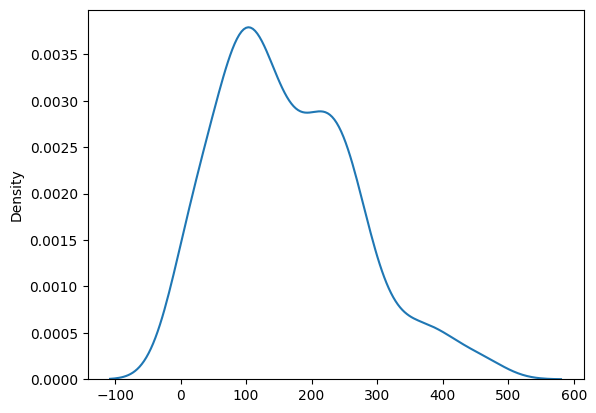

In [6]:
import seaborn as sns
sns.kdeplot(trn['a_len'].tolist())

<Axes: ylabel='Density'>

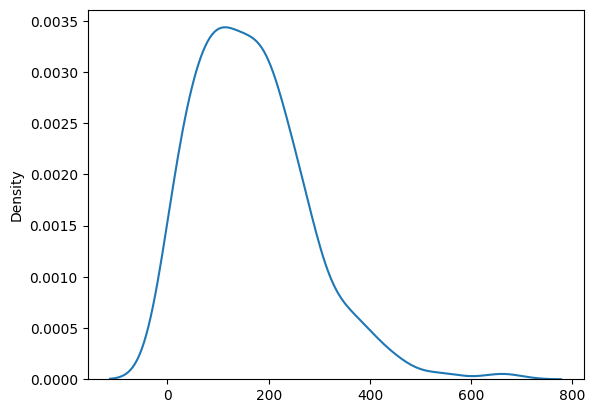

In [7]:
sns.kdeplot(trn['b_len'].tolist())

<Axes: ylabel='Density'>

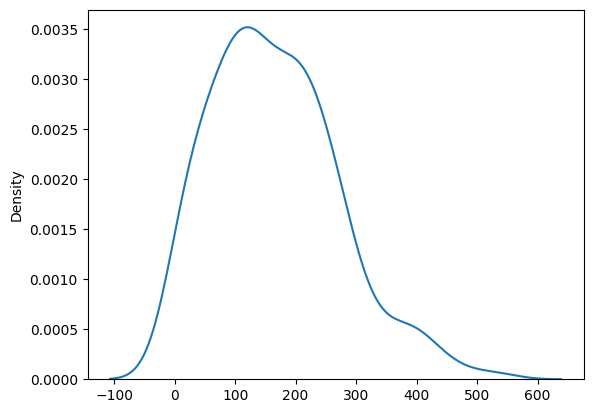

In [8]:
sns.kdeplot(trn['c_len'].tolist())

In [9]:
for i in range(200):
    trn.loc[i,'answer'] = trn.loc[i, trn.loc[i,'answer']]

<Axes: ylabel='Density'>

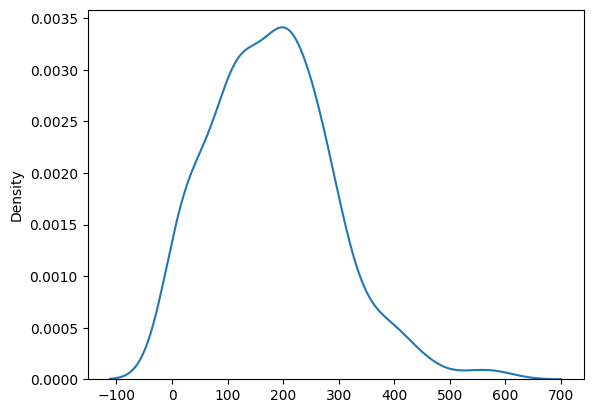

In [11]:
trn['answer_len'] = trn['answer'].apply(lambda x : len(x))
sns.kdeplot(trn['answer_len'].tolist())

In [2]:
import pandas as pd
data = pd.read_csv('./data/新8w数据.csv')

In [3]:
df = pd.read_parquet('./small_wiki_data/data.parquet')

In [4]:
data

,Unnamed: 0,prompt,A,B,C,D,E,answer,wiki_text,page_title,section
0,0,What is the main focus of Russell Epstein's re...,Neural mechanisms of language processing,Neural mechanisms underlying visual scene perc...,Neural mechanisms of memory formation,Neural mechanisms of motor control,Neural mechanisms of emotional processing,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein
1,1,Which brain areas does Russell Epstein's lab s...,Prefrontal cortex and hippocampus,Parahippocampal and retrosplenial cortices,Motor cortex and cerebellum,Amygdala and thalamus,Visual cortex and auditory cortex,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein
2,2,What is the role of the Parahippocampal and re...,Motor control,Emotional processing,Visual scene perception,Spatial navigation,Language processing,D,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein
3,3,Where did Epstein receive his undergraduate de...,University of Chicago,Harvard,Stanford,MIT,Columbia,A,Epstein received an undergraduate degree in ph...,Russell Epstein,Education
4,4,Who was E...n of Computer Vision?,Alan Turing,Alan Yuille,Marvin Minsky,Geoffrey Hinton,Yann LeCun,B,Epstein received an undergraduate degree in ph...,Russell Epstein,Education
...,...,...,...,...,...,...,...,...,...,...,...
80726,80726,Which tournament had the largest prize in Jeop...,Super Jeopardy!,Million Dollar Masters,Tenth Anniversary Tournament,Ultimate Tournament of Champions,Battle of the Decades,D,There have been several special tournaments fe...,Jeopardy!,Tournaments and other events
80727,80727,"How many matches did the ""Greatest of All Time...",One,Two,Three,Four,Five,D,There have been several special tournaments fe...,Jeopardy!,Tournaments and other events
80728,80728,In which year did the Jeopardy! Teen Reunion T...,1998,2008,2009,2010,2011,A,"In November 1998, Jeopardy! traveled to Boston...",Jeopardy!,Tournaments and other events
80729,80729,Which Jeopardy! tournament featured contestant...,Teen Reunion Tournament,Million Dollar Celebrity Invitational,IBM Challenge,All-Star Games,Ultimate Tournament of Champions,B,"In November 1998, Jeopardy! traveled to Boston...",Jeopardy!,Tournaments and other events


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
def word_process(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    return words
stop_words = set(stopwords.words('english'))


def query_process(q):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    keywords = [word for word in words if word not in stop_words]
    return " ".join(keywords)

def recall_doc(q, bm25):
    q = word_process(q)
    res_ids = [item[1] for item in bm25.top_k_sentence(q,  k=1000)]
    return res_ids

from fastbm25 import fastbm25

In [14]:
texts = []
for i in tqdm(range(len(df))):
    text = str(df.loc[i, 'title']) + ' ' + str(df.loc[i, 'text'])
    texts.append(word_process(text)[:100])

100%|██████████| 2101279/2101279 [23:32<00:00, 1488.03it/s] 


In [24]:
texts50 = [item[:50] for item in tqdm(texts)]


100%|██████████| 2101279/2101279 [00:13<00:00, 159147.88it/s]


In [29]:
with open('./tmp/mybm25.pkl','wb') as f:
    pkl.dump(bm25, f)

In [30]:
from fastbm25 import fastbm25

In [31]:
bm25

In [33]:
data['prompt_answer'] = data['prompt'] + ' ' + data['A'] + ' ' + data['B'] + ' ' + data['C'] + ' ' + data['D'] + ' ' + data['E']

In [35]:
search_index = []
for i in tqdm(range(len(data))):
    q = word_process(data.loc[i,'prompt_answer'])
    res_ids = [item[0] for item in bm25.top_k_sentence(q,  k=1000)]
    search_index.append(res_ids)


  0%|          | 8/80731 [00:18<51:10:19,  2.28s/it]


KeyboardInterrupt: 

In [2]:
import pandas as pd
data1 = pd.read_csv('./data/test_context.csv')
data2 = pd.read_csv('./data/test_context (1).csv')

In [3]:
text1 = [item.split('.') for item in data1['context']]
text2 = [item.split('.') for item in data2['context']]

In [9]:
cnt = 0
total = 0
for i in range(200):
    cnt += len(set(text1[i]) & set(text2[i]))
    total += len(set(text2[i]))
cnt / total

0.3011867088607595

In [1]:
import pandas as pd
data = pd.read_parquet('./small_wiki_data_base/data.parquet')

In [3]:
s = set()
for i in data['wiki_id']:
    s.add(int(i))

In [4]:
data

,id,title,text,url,wiki_id,views,paragraph_id,langs
0,5443,Google Translate,Google Translate is a multilingual neural mach...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,0,97
1,5444,Google Translate,Launched in April 2006 as a statistical machin...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,1,97
2,5445,Google Translate,Google Translate is a web-based free-to-user t...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,2,97
3,5446,Google Translate,"Originally, Google Translate was released as a...",https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,3,97
4,5447,Google Translate,"In January 2010, Google introduced an Android ...",https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,4,97
...,...,...,...,...,...,...,...,...
2781647,35167656,Mr. Keynes and the &quot;Classics&quot;,The charge against Hicks that he paid little a...,https://en.wikipedia.org/wiki?curid=56889606,56889606,0.000000,96,0
2781648,35167666,Mr. Keynes and the &quot;Classics&quot;,"The record of the thirties, in major works on ...",https://en.wikipedia.org/wiki?curid=56889606,56889606,0.000000,97,0
2781649,35167676,Mr. Keynes and the &quot;Classics&quot;,"Hicks himself retracted his support for the ""I...",https://en.wikipedia.org/wiki?curid=56889606,56889606,0.000000,98,0
2781650,35167686,Mr. Keynes and the &quot;Classics&quot;,The argument of this paper is hard to follow a...,https://en.wikipedia.org/wiki?curid=56889606,56889606,0.000000,99,0


In [5]:
len(s)

277046

In [7]:
df = pd.read_parquet('./wiki_data/my_index.parquet')

In [9]:
df['id'] = df['id'].apply(lambda x : int(x))

In [10]:
df = df[df['id'].isin(s)]

In [12]:
df = df.reset_index(drop=True)

In [17]:
alls = []
from tqdm.auto import tqdm
for item in tqdm(df['file'].unique()):
    print(item)
    tmp = pd.read_parquet(f'./wiki_data/{item}')
    tmp['id'] = tmp['id'].apply(lambda x : int(x))
    tmp = tmp[tmp['id'].isin(s)]
    alls.append(tmp)

  0%|          | 0/28 [00:00<?, ?it/s]

a.parquet


  4%|▎         | 1/28 [00:06<02:50,  6.32s/it]

b.parquet


  7%|▋         | 2/28 [00:11<02:21,  5.45s/it]

c.parquet


 11%|█         | 3/28 [00:17<02:28,  5.94s/it]

d.parquet


 14%|█▍        | 4/28 [00:23<02:18,  5.76s/it]

e.parquet


 18%|█▊        | 5/28 [00:27<02:03,  5.37s/it]

f.parquet


 21%|██▏       | 6/28 [00:31<01:44,  4.77s/it]

g.parquet


 25%|██▌       | 7/28 [00:36<01:42,  4.90s/it]

h.parquet


 29%|██▊       | 8/28 [00:41<01:40,  5.04s/it]

i.parquet


 32%|███▏      | 9/28 [00:45<01:27,  4.61s/it]

j.parquet


 36%|███▌      | 10/28 [00:51<01:32,  5.11s/it]

k.parquet


 39%|███▉      | 11/28 [00:56<01:23,  4.91s/it]

l.parquet


 43%|████▎     | 12/28 [01:08<01:52,  7.01s/it]

m.parquet


 46%|████▋     | 13/28 [01:18<01:58,  7.92s/it]

n.parquet


 50%|█████     | 14/28 [01:22<01:34,  6.75s/it]

number.parquet


 54%|█████▎    | 15/28 [01:31<01:35,  7.38s/it]

o.parquet


 57%|█████▋    | 16/28 [01:33<01:10,  5.91s/it]

other.parquet


 61%|██████    | 17/28 [01:34<00:48,  4.38s/it]

p.parquet


 64%|██████▍   | 18/28 [01:40<00:49,  5.00s/it]

q.parquet


 68%|██████▊   | 19/28 [01:41<00:32,  3.66s/it]

r.parquet


 71%|███████▏  | 20/28 [01:48<00:37,  4.73s/it]

s.parquet


 75%|███████▌  | 21/28 [01:59<00:46,  6.60s/it]

t.parquet


 79%|███████▊  | 22/28 [02:09<00:45,  7.57s/it]

u.parquet


 82%|████████▏ | 23/28 [02:11<00:29,  5.99s/it]

v.parquet


 86%|████████▌ | 24/28 [02:13<00:19,  4.78s/it]

w.parquet


 89%|████████▉ | 25/28 [02:17<00:13,  4.59s/it]

x.parquet


 93%|█████████▎| 26/28 [02:18<00:06,  3.39s/it]

y.parquet


 96%|█████████▋| 27/28 [02:19<00:02,  2.69s/it]

z.parquet


100%|██████████| 28/28 [02:20<00:00,  5.01s/it]


In [18]:
alls = pd.concat(alls,axis=0).reset_index(drop=True)

In [19]:
alls

,id,title,text,categories
0,2828410,A (musical note),A or La is the sixth note and the tenth semito...,[Musical notes]
1,11506718,A B Wood Medal,The A B Wood Medal is a prize awarded annually...,"[Physics awards, British science and technolog..."
2,65261614,A Blackbird in Silver,A Blackbird in Silver is a novel by Freda Warr...,[1986 novels]
3,64286234,A Book of Numbers,A Book of Numbers () is a book by John Grant p...,[1982 books]
4,64829297,A Box of Nothing,A Box of Nothing is a novel by Peter Dickinson...,[1985 novels]
...,...,...,...,...
264048,6516037,Zyword,is a single-volume manga created by ex-Clamp m...,"[Kadokawa Shoten manga, Shōjo manga, Tamayo Ak..."
264049,14755807,Zyxin,Zyxin is a protein that in humans is encoded b...,[Cytoskeleton]
264050,1163782,Zzap!64,Zzap!64 was a computer games magazine covering...,"[1985 establishments in the United Kingdom, 19..."
264051,567286,ZÈRTZ,ZÈRTZ is the third game in the GIPF Project of...,"[Board games introduced in 1999, Abstract stra..."


In [27]:
merged_df = data.groupby('wiki_id')['text'].agg(lambda x: ''.join(x)).reset_index(drop=True)

In [30]:
x = set(merged_df.tolist())

In [31]:
y = set(alls['text'].tolist())

In [32]:
len(x & y)

7

In [33]:
alls

,id,title,text,categories
0,2828410,A (musical note),A or La is the sixth note and the tenth semito...,[Musical notes]
1,11506718,A B Wood Medal,The A B Wood Medal is a prize awarded annually...,"[Physics awards, British science and technolog..."
2,65261614,A Blackbird in Silver,A Blackbird in Silver is a novel by Freda Warr...,[1986 novels]
3,64286234,A Book of Numbers,A Book of Numbers () is a book by John Grant p...,[1982 books]
4,64829297,A Box of Nothing,A Box of Nothing is a novel by Peter Dickinson...,[1985 novels]
...,...,...,...,...
264048,6516037,Zyword,is a single-volume manga created by ex-Clamp m...,"[Kadokawa Shoten manga, Shōjo manga, Tamayo Ak..."
264049,14755807,Zyxin,Zyxin is a protein that in humans is encoded b...,[Cytoskeleton]
264050,1163782,Zzap!64,Zzap!64 was a computer games magazine covering...,"[1985 establishments in the United Kingdom, 19..."
264051,567286,ZÈRTZ,ZÈRTZ is the third game in the GIPF Project of...,"[Board games introduced in 1999, Abstract stra..."


In [2]:
alls = pd.read_parquet('./wiki_data/small_wiki_data.parquet')

In [15]:
alls.loc[0,'text']

'A or La is the sixth note and the tenth semitone of the fixed-do solfège. Its enharmonic equivalents are B (B double flat) which is a diatonic semitone above A and G (G double sharp) which is a diatonic semitone below A. "A" is generally used as a standard for tuning. When the orchestra tunes, the oboe plays an "A" and the rest of the instruments tune to match that pitch. Every string instrument in the orchestra has an A string, from which each player can tune the rest of their instrument. "A" is also used in combination with a number (e.g. A-440) to label the pitch standard. The number designates the frequency in hertz. A lower number equals a lower pitch. The International Standards Organization (ISO) has standardized the pitch at A-440. However, tuning has varied over time, geographical region, or instrument maker. In 17th-century Europe, tunings ranged from about A-374 to A-403, approximately two to three semitones below A-440. Historical examples exist of instruments, tuning fork

In [18]:
alls

,id,title,text,categories
0,2828410,A (musical note),A or La is the sixth note and the tenth semito...,[Musical notes]
1,11506718,A B Wood Medal,The A B Wood Medal is a prize awarded annually...,"[Physics awards, British science and technolog..."
2,65261614,A Blackbird in Silver,A Blackbird in Silver is a novel by Freda Warr...,[1986 novels]
3,64286234,A Book of Numbers,A Book of Numbers () is a book by John Grant p...,[1982 books]
4,64829297,A Box of Nothing,A Box of Nothing is a novel by Peter Dickinson...,[1985 novels]
...,...,...,...,...
264048,6516037,Zyword,is a single-volume manga created by ex-Clamp m...,"[Kadokawa Shoten manga, Shōjo manga, Tamayo Ak..."
264049,14755807,Zyxin,Zyxin is a protein that in humans is encoded b...,[Cytoskeleton]
264050,1163782,Zzap!64,Zzap!64 was a computer games magazine covering...,"[1985 establishments in the United Kingdom, 19..."
264051,567286,ZÈRTZ,ZÈRTZ is the third game in the GIPF Project of...,"[Board games introduced in 1999, Abstract stra..."


In [19]:
new = []
for i in range(len(alls)):
    ids = alls.loc[i,'id']
    title = alls.loc[i,'title']
    text = alls.loc[i,'text'].split('###')
    for item in text:
        if len(item) < 2:
            continue
        if len(item.split(' ')) <= 3:
            continue
        new.append({'id':ids, 'title':title, 'text':item})

In [20]:
new = pd.DataFrame(new)

In [21]:
new

,id,title,text
0,2828410,A (musical note),A or La is the sixth note and the tenth semito...
1,2828410,A (musical note),Scientific designation Helmholtz designation ...
2,2828410,A (musical note),Common scales beginning on A
3,2828410,A (musical note),* A major: A B C D E F G A *A natural minor: ...
4,2828410,A (musical note),* A Ionian: A B C D E F G A * A Dorian: A B C...
...,...,...,...
2249683,49505601,Zététique,Zététique seems to have entered the French la...
2249684,49505601,Zététique,Zététique organisations
2249685,49505601,Zététique,Past ans current organisations that consider ...
2249686,49505601,Zététique,Marcello Truzzi and others who are critical o...


In [22]:
new.to_parquet('./wiki_data/680w_small_split.parquet')

In [1]:
import pandas as pd
new = pd.read_parquet('./wiki_data/680w_small_split.parquet')

In [13]:
new = new[new['text'].apply(lambda x : len(x.split(' ')) > 50)]

In [14]:
new = new.reset_index(drop=True)

In [15]:
new.to_parquet('./wiki_data/680w_small_split_small.parquet')

In [16]:
new

,id,title,text
0,2828410,A (musical note),A or La is the sixth note and the tenth semito...
1,2828410,A (musical note),Scientific designation Helmholtz designation ...
2,2828410,A (musical note),* A major: A B C D E F G A *A natural minor: ...
3,2828410,A (musical note),* A Ionian: A B C D E F G A * A Dorian: A B C...
4,2828410,A (musical note),* A Ascending melodic minor: A B C D E F G A ...
...,...,...,...
1129499,567286,ZÈRTZ,A short Blitz version of the game can be play...
1129500,49505601,Zététique,Zététique (from Ancient Greek: ζητητικός zētēt...
1129501,49505601,Zététique,Zététique seems to have entered the French la...
1129502,49505601,Zététique,Past ans current organisations that consider ...


In [10]:
df = pd.read_parquet('./small_wiki_data_base/data.parquet')

In [12]:
df

,id,title,text,url,wiki_id,views,paragraph_id,langs
0,5443,Google Translate,Google Translate is a multilingual neural mach...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,0,97
1,5444,Google Translate,Launched in April 2006 as a statistical machin...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,1,97
2,5445,Google Translate,Google Translate is a web-based free-to-user t...,https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,2,97
3,5446,Google Translate,"Originally, Google Translate was released as a...",https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,3,97
4,5447,Google Translate,"In January 2010, Google introduced an Android ...",https://en.wikipedia.org/wiki?curid=3235536,3235536,4305.652832,4,97
...,...,...,...,...,...,...,...,...
2781647,35167656,Mr. Keynes and the &quot;Classics&quot;,The charge against Hicks that he paid little a...,https://en.wikipedia.org/wiki?curid=56889606,56889606,0.000000,96,0
2781648,35167666,Mr. Keynes and the &quot;Classics&quot;,"The record of the thirties, in major works on ...",https://en.wikipedia.org/wiki?curid=56889606,56889606,0.000000,97,0
2781649,35167676,Mr. Keynes and the &quot;Classics&quot;,"Hicks himself retracted his support for the ""I...",https://en.wikipedia.org/wiki?curid=56889606,56889606,0.000000,98,0
2781650,35167686,Mr. Keynes and the &quot;Classics&quot;,The argument of this paper is hard to follow a...,https://en.wikipedia.org/wiki?curid=56889606,56889606,0.000000,99,0


In [17]:
race = pd.read_csv('./data/RACE_with_context_original.csv')

In [20]:
race.loc[0,'context']

'Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.\nGiven that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.\n"Surgery ," one replied.\nI was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .\nOne girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"\nAt that point, I was shocked. I am short, I can\'t deny that, but I don\'t think I would put m

In [1]:
import pandas as pd
trn1 = pd.read_csv('./data/新8w数据.csv')
trn2 = pd.read_csv('./data/7w8_crawl_dataset.csv')

In [4]:
trn = pd.concat([trn1, trn2],axis=0).reset_index(drop=True)

In [5]:
trn

,Unnamed: 0,prompt,A,B,C,D,E,answer,wiki_text,page_title,section,id,page_id,stem_label,prompt_answer
0,0,What is the main focus of Russell Epstein's re...,Neural mechanisms of language processing,Neural mechanisms underlying visual scene perc...,Neural mechanisms of memory formation,Neural mechanisms of motor control,Neural mechanisms of emotional processing,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN,NaN,NaN,NaN
1,1,Which brain areas does Russell Epstein's lab s...,Prefrontal cortex and hippocampus,Parahippocampal and retrosplenial cortices,Motor cortex and cerebellum,Amygdala and thalamus,Visual cortex and auditory cortex,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN,NaN,NaN,NaN
2,2,What is the role of the Parahippocampal and re...,Motor control,Emotional processing,Visual scene perception,Spatial navigation,Language processing,D,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN,NaN,NaN,NaN
3,3,Where did Epstein receive his undergraduate de...,University of Chicago,Harvard,Stanford,MIT,Columbia,A,Epstein received an undergraduate degree in ph...,Russell Epstein,Education,NaN,NaN,NaN,NaN
4,4,Who was E...n of Computer Vision?,Alan Turing,Alan Yuille,Marvin Minsky,Geoffrey Hinton,Yann LeCun,B,Epstein received an undergraduate degree in ph...,Russell Epstein,Education,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158734,78003,What is the inscription on the plinth of the a...,Rotary Armillary,Service Above Self,This Armillary was presented to the people of ...,The Rotary Club of Cheam has joined with the R...,December 2000,B,The Millennium Dial Armillary is one of six pi...,Sutton armillary,NaN,78140.0,43629419.0,M,What is the inscription on the plinth of the a...
158735,78004,How was the Millennium Dial Armillary funded?,By the London Borough of Sutton,By the Rotary Club,By the sponsors listed on the plinth inscription,By the residents of Sutton,By a joint effort between the Rotary Club and ...,C,The Millennium Dial Armillary is one of six pi...,Sutton armillary,NaN,78141.0,43629419.0,M,How was the Millennium Dial Armillary funded? ...
158736,78005,What is the Ukrainian Physicists' Tournament f...,A competition for secondary school students to...,A competition for university students to solve...,A competition for international physicists to ...,A research project competition for university ...,A creative team competition for university stu...,E,Ukrainian Physicists' Tournament for Universit...,Ukrainian Physicists' Tournament for Universit...,NaN,78142.0,14320529.0,M,What is the Ukrainian Physicists' Tournament f...
158737,78006,When was the first Open Physicists' Tournament...,2001,2005,2010,2015,2020,A,Ukrainian Physicists' Tournament for Universit...,Ukrainian Physicists' Tournament for Universit...,NaN,78143.0,14320529.0,M,When was the first Open Physicists' Tournament...


In [8]:
trn[~(trn['A'].isna() | trn['B'].isna() | trn['C'].isna() | trn['D'].isna() | trn['E'].isna())].reset_index(drop=True)

,Unnamed: 0,prompt,A,B,C,D,E,answer,wiki_text,page_title,section,id,page_id,stem_label,prompt_answer
0,0,What is the main focus of Russell Epstein's re...,Neural mechanisms of language processing,Neural mechanisms underlying visual scene perc...,Neural mechanisms of memory formation,Neural mechanisms of motor control,Neural mechanisms of emotional processing,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN,NaN,NaN,NaN
1,1,Which brain areas does Russell Epstein's lab s...,Prefrontal cortex and hippocampus,Parahippocampal and retrosplenial cortices,Motor cortex and cerebellum,Amygdala and thalamus,Visual cortex and auditory cortex,B,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN,NaN,NaN,NaN
2,2,What is the role of the Parahippocampal and re...,Motor control,Emotional processing,Visual scene perception,Spatial navigation,Language processing,D,Russell Epstein is a professor of psychology a...,Russell Epstein,Russell Epstein,NaN,NaN,NaN,NaN
3,3,Where did Epstein receive his undergraduate de...,University of Chicago,Harvard,Stanford,MIT,Columbia,A,Epstein received an undergraduate degree in ph...,Russell Epstein,Education,NaN,NaN,NaN,NaN
4,4,Who was E...n of Computer Vision?,Alan Turing,Alan Yuille,Marvin Minsky,Geoffrey Hinton,Yann LeCun,B,Epstein received an undergraduate degree in ph...,Russell Epstein,Education,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158612,78003,What is the inscription on the plinth of the a...,Rotary Armillary,Service Above Self,This Armillary was presented to the people of ...,The Rotary Club of Cheam has joined with the R...,December 2000,B,The Millennium Dial Armillary is one of six pi...,Sutton armillary,NaN,78140.0,43629419.0,M,What is the inscription on the plinth of the a...
158613,78004,How was the Millennium Dial Armillary funded?,By the London Borough of Sutton,By the Rotary Club,By the sponsors listed on the plinth inscription,By the residents of Sutton,By a joint effort between the Rotary Club and ...,C,The Millennium Dial Armillary is one of six pi...,Sutton armillary,NaN,78141.0,43629419.0,M,How was the Millennium Dial Armillary funded? ...
158614,78005,What is the Ukrainian Physicists' Tournament f...,A competition for secondary school students to...,A competition for university students to solve...,A competition for international physicists to ...,A research project competition for university ...,A creative team competition for university stu...,E,Ukrainian Physicists' Tournament for Universit...,Ukrainian Physicists' Tournament for Universit...,NaN,78142.0,14320529.0,M,What is the Ukrainian Physicists' Tournament f...
158615,78006,When was the first Open Physicists' Tournament...,2001,2005,2010,2015,2020,A,Ukrainian Physicists' Tournament for Universit...,Ukrainian Physicists' Tournament for Universit...,NaN,78143.0,14320529.0,M,When was the first Open Physicists' Tournament...


In [10]:
trn.loc[0,'prompt']

"What is the main focus of Russell Epstein's research?"

In [11]:
trn.loc[0,'wiki_text']

'Russell Epstein is a professor of psychology at the University of Pennsylvania, who studies neural mechanisms underlying visual scene perception, event perception, object recognition, and spatial navigation in humans. His lab studies the role of the Parahippocampal and retrosplenial cortices in determining how people orient themselves relative to their surroundings.'

In [1]:
import pandas as pd
trn1 = pd.read_parquet('./data/7w_1_bm25_blendrecall_top1000_top30.parquet')
trn2 = pd.read_parquet('./data/7w_2_bm25_blendrecall_top1000_top30.parquet')

In [2]:
trn = pd.concat([trn1,trn2],axis=0).reset_index(drop=True)

,Unnamed: 0,id,prompt,A,B,C,D,E,answer,wiki_text,page_id,page_title,stem_label,prompt_answer,index,top1000_to_top30_ids
0,0,0,What does the nullity of a graph in graph theo...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The multiplicity of the eigenvalue 0 in the sp...,The number of components of the graph,D,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What does the nullity of a graph in graph theo...,0,"[3876952, 4778094, 74006, 1084899, 5320593, 54..."
1,1,1,"In the matrix theory of graphs, what is the nu...",n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,A,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,"In the matrix theory of graphs, what is the nu...",1,"[3876952, 4778094, 3876954, 4775661, 1015519, ..."
2,2,2,Which term is more commonly used to refer to t...,Nullity of the adjacency matrix,Multiplicity of the eigenvalue 0,Cycle rank,Cyclomatic number,Circuit rank,C,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,Which term is more commonly used to refer to t...,2,"[3876952, 4778094, 1111978, 1015508, 3418262, ..."
3,3,3,What is the formula for calculating the nullit...,n − r,m − n + c,n − c,The nullity of the graph,The number of components of the graph,B,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What is the formula for calculating the nullit...,3,"[3876952, 4778094, 1015508, 3418253, 2688656, ..."
4,4,4,What can the nullity of the graph represent in...,The number of vertices in the graph,The number of edges in the graph,The rank of the adjacency matrix,The number of components of the graph,The rank of the oriented incidence matrix,E,The nullity of a graph in the mathematical sub...,17458663,Nullity (graph theory),M,What can the nullity of the graph represent in...,4,"[3876952, 4778094, 1993693, 1084899, 1015508, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78004,78003,78140,What is the inscription on the plinth of the a...,Rotary Armillary,Service Above Self,This Armillary was presented to the people of ...,The Rotary Club of Cheam has joined with the R...,December 2000,B,The Millennium Dial Armillary is one of six pi...,43629419,Sutton armillary,M,What is the inscription on the plinth of the a...,38999,"[5456608, 3188648, 5456506, 5456632, 858659, 3..."
78005,78004,78141,How was the Millennium Dial Armillary funded?,By the London Borough of Sutton,By the Rotary Club,By the sponsors listed on the plinth inscription,By the residents of Sutton,By a joint effort between the Rotary Club and ...,C,The Millennium Dial Armillary is one of six pi...,43629419,Sutton armillary,M,How was the Millennium Dial Armillary funded? ...,39000,"[5456608, 1320182, 5456506, 5456671, 3545326, ..."
78006,78005,78142,What is the Ukrainian Physicists' Tournament f...,A competition for secondary school students to...,A competition for university students to solve...,A competition for international physicists to ...,A research project competition for university ...,A creative team competition for university stu...,E,Ukrainian Physicists' Tournament for Universit...,14320529,Ukrainian Physicists' Tournament for Universit...,M,What is the Ukrainian Physicists' Tournament f...,39001,"[5873747, 2365219, 5313060, 4566202, 4403394, ..."
78007,78006,78143,When was the first Open Physicists' Tournament...,2001,2005,2010,2015,2020,A,Ukrainian Physicists' Tournament for Universit...,14320529,Ukrainian Physicists' Tournament for Universit...,M,When was the first Open Physicists' Tournament...,39002,"[5873747, 4403394, 2365219, 2362985, 5894257, ..."


In [8]:
used = pd.read_parquet('./data/10w_bm25_top1000_top20.parquet')

In [9]:
used = used[used['type'] == '6w'].reset_index(drop=True)
used

,prompt,context,A,B,C,D,E,answer,source,type,id,prompt_answer,index,top1000_to_top20_ids
0,What is physical mathematics?,None,The study of physically motivated mathematics,The study of mathematical physics,The study of mathematics in physical contexts,The study of mathematical equations,The study of mathematical operations,A,NaN,6w,0.0,What is physical mathematics? The study of phy...,60347,"[3415292, 4816884, 4566100, 1431524, 1086274, ..."
1,Who wrote Physical Arithmetic in 1885?,None,Margaret Osler,Alexander Macfarlane,Alhazen,Galileo,Newton,B,NaN,6w,1.0,Who wrote Physical Arithmetic in 1885? Margare...,60348,"[4566100, 4725861, 2279683, 1636032, 2209614, ..."
2,What did the Mathematical Tripos at Cambridge ...,None,Pure mathematics,Applied mathematics,Mixed mathematics,Fluxional calculus,Physical problems,C,NaN,6w,2.0,What did the Mathematical Tripos at Cambridge ...,60349,"[4566100, 3415219, 4453626, 237664, 3749052, 5..."
3,What mathematical representation is used for m...,None,Complex numbers,Quaternions,Linear algebra,Fluxional calculus,Mixed mathematics,C,NaN,6w,3.0,What mathematical representation is used for m...,60350,"[4566100, 4948326, 2279683, 4725867, 4948333, ..."
4,What did the early expressions of kinematics a...,None,Causality,Forces,Mathematical physics,Fluxional calculus,Mixed mathematics,C,NaN,6w,4.0,What did the early expressions of kinematics a...,60351,"[4566100, 2209563, 5689699, 2977786, 4566196, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48074,What is Sequenom known for developing?,None,Laboratory genetic tests for infertility,Non-invasive prenatal genetic tests,Diagnostic and testing devices for cancer,Molecular technologies for heart disease,Clinical molecular genetics tests for diabetes,B,NaN,6w,48074.0,What is Sequenom known for developing? Laborat...,108421,"[5146451, 3041911, 5405936, 4310738, 4716080, ..."
48075,Which company acquired Sequenom in 2016?,None,LabCorp,Agena Bioscience,Ariosa,PerkinElmer,Natera,A,NaN,6w,48075.0,Which company acquired Sequenom in 2016? LabCo...,108422,"[5146451, 344189, 2907347, 2907348, 4993523, 3..."
48076,Which company did Sequenom sell its bioscience...,None,Natera,PerkinElmer,Agena Bioscience,LabCorp,Ravgen,C,NaN,6w,48076.0,Which company did Sequenom sell its bioscience...,108423,"[5146451, 2362377, 2907347, 2907348, 3605780, ..."
48077,Which patent battle did Sequenom enter in 2012?,None,Patent battle with Ariosa,Patent battle with Natera,Patent battle with Illumina,Patent battle with Ravgen,Patent battle with PerkinElmer,A,NaN,6w,48077.0,Which patent battle did Sequenom enter in 2012...,108424,"[5146451, 344189, 2893111, 3701223, 945760, 38..."


In [10]:
used['prompt_answer'] = used['prompt'] + used['A'] + used['B'] + used['C'] + used['D'] + used['E']
trn['prompt_answer'] = trn['prompt'] + trn['A'] + trn['B'] + trn['C'] + trn['D'] + trn['E']

In [13]:
use = set(used['prompt_answer'].tolist())
trn = trn[~trn['prompt_answer'].isin(use)].reset_index(drop=True)

In [15]:
trn['top1000_to_top20_ids'] = trn['top1000_to_top30_ids'].apply(lambda x : x[:20])

In [17]:
len(trn.loc[0,'top1000_to_top20_ids'])

20

In [19]:
trn.to_parquet('./data/7w8中除掉之前4w剩下的3w_top1000_top20.parquet')

In [20]:
trn = []
for i in range(20):
    trn.append(pd.read_pickle(f'./tmp/10w_bm25_top1000_top20_sentence_part{i}.pkl'))

In [21]:
for i in range(6):
    trn.append(pd.read_pickle(f'./tmp/7w8中除掉之前4w剩下的3w_top1000_top20_sentence_part{i}.pkl'))

In [22]:
trn = pd.concat(trn, axis=0).reset_index(drop=True)

In [24]:
trn['type'] = trn['type'].fillna('3w')

In [26]:
def change(s):
    if s == '6w':
        return '4w8'
    if s == '4w8':
        return '6w'
    return '3w'
trn['type'] = trn['type'].apply(lambda x : change(x))

In [30]:
trn = trn[['prompt','context','A','B','C','D','E','answer','type']]

In [31]:
trn.to_parquet('./data/13w_recall_Top1000_Top20_sentence.parquet')

In [1]:
import pandas as pd
trn = pd.read_parquet('./data/13w_recall_Top1000_Top20_sentence.parquet')

In [5]:
trn.loc[0,'context']

array(['Eunice Fay McKenzie (February 19, 1918 – April 16, 2019) was an American actress and singer.',
       'She also entertained the troops with her former screen partner, Gene Autry. ===Later career=== After World War II, McKenzie retired from films to raise her two children.',
       'She was briefly billed as Fay Shannon. ==Biography== ===Early life and silent film=== McKenzie was born on February 19, 1918, in Hollywood, California, to show business parents, film actor Eva (née Heazlitt) and Irish American actor/director Robert McKenzie.Mike Fitzgerald, "An Interview with ...',
       'She starred in silent films as a child, and then sound films as an adult, but perhaps she is best known for her leading roles opposite Gene Autry in the early 1940s in five horse opera features.',
       "She trained at the Guildhall School of Music and Drama. ==Career== ===Theatre=== McKenzie's early West End musical credits include Maggie May (1966), Mame (1969), and Company (1971).",
       'Kno

In [9]:
trn['prompt_answer'] = trn.apply(lambda row: ' '.join(str(row[field]) for field in ['prompt', 'A', 'B', 'C', 'D', 'E']), axis=1)
trn.drop_duplicates(subset='prompt_answer')

,prompt,context,A,B,C,D,E,answer,type,prompt_answer
0,"In relation to Eunice Fay McKenzie's career, w...","[Eunice Fay McKenzie (February 19, 1918 – Apri...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B,6w,"In relation to Eunice Fay McKenzie's career, w..."
1,How does Modified Newtonian Dynamics (MOND) im...,[While almost all astrophysicists today reject...,MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E,6w,How does Modified Newtonian Dynamics (MOND) im...
2,Which of the following statements accurately d...,[Ray Montgomerie (born 17 April 1961) is a Sco...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B,6w,Which of the following statements accurately d...
3,What is the significance of the Museum of the ...,[The Museum of the Occupation of Latvia () is ...,The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C,6w,What is the significance of the Museum of the ...
4,What was the previous name of the Christian Sc...,[It was named the Evangelical School for the D...,The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D,6w,What was the previous name of the Christian Sc...
...,...,...,...,...,...,...,...,...,...,...
138354,What is the inscription on the plinth of the a...,"[It serves three purposes: firstly, simply to ...",Rotary Armillary,Service Above Self,This Armillary was presented to the people of ...,The Rotary Club of Cheam has joined with the R...,December 2000,B,3w,What is the inscription on the plinth of the a...
138355,How was the Millennium Dial Armillary funded?,[The Millennium Dial Armillary is one of six p...,By the London Borough of Sutton,By the Rotary Club,By the sponsors listed on the plinth inscription,By the residents of Sutton,By a joint effort between the Rotary Club and ...,C,3w,How was the Millennium Dial Armillary funded? ...
138356,What is the Ukrainian Physicists' Tournament f...,"[Since then, Ukrainian Physicists' Tournament ...",A competition for secondary school students to...,A competition for university students to solve...,A competition for international physicists to ...,A research project competition for university ...,A creative team competition for university stu...,E,3w,What is the Ukrainian Physicists' Tournament f...
138357,When was the first Open Physicists' Tournament...,[The first Open Physicists' Tournament for Uni...,2001,2005,2010,2015,2020,A,3w,When was the first Open Physicists' Tournament...


In [1]:
import numpy as np
pred = []
pred.append(np.array([23.12,4123.123]))
pred.append(np.array([213.12,312.32]))

In [ ]:
pred[0] + p

In [1]:
import pandas as pd
data = pd.read_csv('./data/10w_bm25_20_20_merge.csv')
trn = pd.read_csv('./data/train_10w_bm25召回_训LLM用.csv')

In [7]:
trn

,prompt,context,A,B,C,D,E,answer
0,What is physical mathematics?,The subject of physical mathematics is concern...,The study of physically motivated mathematics,The study of mathematical physics,The study of mathematics in physical contexts,The study of mathematical equations,The study of mathematical operations,A
1,Who wrote Physical Arithmetic in 1885?,The details of physical units and their manipu...,Margaret Osler,Alexander Macfarlane,Alhazen,Galileo,Newton,B
2,What did the Mathematical Tripos at Cambridge ...,At Cambridge University the Mathematical Tripo...,Pure mathematics,Applied mathematics,Mixed mathematics,Fluxional calculus,Physical problems,C
3,What mathematical representation is used for m...,The details of physical units and their manipu...,Complex numbers,Quaternions,Linear algebra,Fluxional calculus,Mixed mathematics,C
4,What did the early expressions of kinematics a...,Accordingly these early expressions of kinemat...,Causality,Forces,Mathematical physics,Fluxional calculus,Mixed mathematics,C
...,...,...,...,...,...,...,...,...
107342,"The outer ear, or ear canal, carries sound to ...",The difference in pressure between internal or...,aorta,ear lobe,eardrum,lungs,NaN,C
107343,What sport involves people quickly finding des...,The term is derived from the use of the term f...,mapping,NaN,orienteering,patterning,sticking,C
107344,Almost all earthquakes occur at which place?,Tectonic processes typically occur at plate bo...,mountains,land boundaries,plate boundaries,continental shelf,NaN,C
107345,"Melting glaciers, rising temperatures and drou...",Wildfires in Italy can be a problem. == Impact...,nature's natural cycle,air pollution,global warming,sudden warming,NaN,C


In [1]:
import pandas as pd
data = pd.read_csv('./data/10w_bm25_20_20_merge.csv')

In [2]:
data

,Unnamed: 0,prompt,context,A,B,C,D,E,answer,source,type,id
0,0,"In relation to Eunice Fay McKenzie's career, w...","She starred in silent films as a child, and th...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B,1.0,6w,NaN
1,1,How does Modified Newtonian Dynamics (MOND) im...,"In cosmology, the missing baryon problem is an...",MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E,1.0,6w,NaN
2,2,Which of the following statements accurately d...,Ray Montgomerie (born 17 April 1961) is a Scot...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B,1.0,6w,NaN
3,3,What is the significance of the Museum of the ...,thumb|One of the exhibit halls inside the Muse...,The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C,1.0,6w,NaN
4,4,What was the previous name of the Christian Sc...,The Christian School and Chapel for the Deaf (...,The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D,1.0,6w,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
108421,108421,What is Sequenom known for developing?,"It develops enabling molecular technologies, a...",Laboratory genetic tests for infertility,Non-invasive prenatal genetic tests,Diagnostic and testing devices for cancer,Molecular technologies for heart disease,Clinical molecular genetics tests for diabetes,B,NaN,4w8,48074.0
108422,108422,Which company acquired Sequenom in 2016?,The acquisition was completed in September 201...,LabCorp,Agena Bioscience,Ariosa,PerkinElmer,Natera,A,NaN,4w8,48075.0
108423,108423,Which company did Sequenom sell its bioscience...,In June 2014 the company sold its biosciences ...,Natera,PerkinElmer,Agena Bioscience,LabCorp,Ravgen,C,NaN,4w8,48076.0
108424,108424,Which patent battle did Sequenom enter in 2012?,Other companies and universities that are work...,Patent battle with Ariosa,Patent battle with Natera,Patent battle with Illumina,Patent battle with Ravgen,Patent battle with PerkinElmer,A,NaN,4w8,48077.0


In [3]:
data = pd.read_csv('./data/RACE_with_context_original.csv')

In [5]:
data.loc[0,'context']

'Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.\nGiven that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.\n"Surgery ," one replied.\nI was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .\nOne girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"\nAt that point, I was shocked. I am short, I can\'t deny that, but I don\'t think I would put m

In [1]:
import pandas as pd
import os
data = []
listdir = os.listdir('./wiki_data')
listdir = sorted(listdir)
for file in listdir:
    if file == 'my_index.parquet' or 'ipynb' in file:
        continue
    print(file)
    data.append(pd.read_parquet(os.path.join('./wiki_data',file)))

a.parquet
b.parquet
c.parquet
d.parquet
e.parquet
f.parquet
g.parquet
h.parquet
i.parquet
j.parquet
k.parquet
l.parquet
m.parquet
n.parquet
number.parquet
o.parquet
other.parquet
p.parquet
q.parquet
r.parquet
s.parquet
t.parquet
u.parquet
v.parquet
w.parquet
x.parquet
y.parquet
z.parquet


In [2]:
data = pd.concat(data,axis=0).reset_index(drop=True)

In [3]:
import numpy
subs = numpy.array_split(data, 100)

In [5]:
for i in range(len(subs)):
    sub = subs[i].reset_index(drop=True)
    sub.to_parquet(f'./tmp/680w_token/data_{i}.parquet')

In [5]:
import pandas as pd
data1 = pd.read_parquet('./small_wiki_data_base/data.parquet')
data2 = pd.read_parquet('./small_wiki_data_base/680w_kmeans_split_2500.parquet')

In [6]:
data = pd.concat([data1, data2],axis=0).reset_index(drop=True)

In [7]:
data

,id,title,text,url,wiki_id,views,paragraph_id,langs
0,5443,Google Translate,Google Translate is a multilingual neural mach...,https://en.wikipedia.org/wiki?curid=3235536,3235536.0,4305.652832,0.0,97.0
1,5444,Google Translate,Launched in April 2006 as a statistical machin...,https://en.wikipedia.org/wiki?curid=3235536,3235536.0,4305.652832,1.0,97.0
2,5445,Google Translate,Google Translate is a web-based free-to-user t...,https://en.wikipedia.org/wiki?curid=3235536,3235536.0,4305.652832,2.0,97.0
3,5446,Google Translate,"Originally, Google Translate was released as a...",https://en.wikipedia.org/wiki?curid=3235536,3235536.0,4305.652832,3.0,97.0
4,5447,Google Translate,"In January 2010, Google introduced an Android ...",https://en.wikipedia.org/wiki?curid=3235536,3235536.0,4305.652832,4.0,97.0
...,...,...,...,...,...,...,...,...
3119023,70907699,1988 Olympic commemorative coins,The 1988 Olympic commemorative coins are a ser...,NaN,NaN,NaN,NaN,NaN
3119024,10441602,Ionian Technologies,Ionian Technologies Inc. was a United States B...,NaN,NaN,NaN,NaN,NaN
3119025,22379984,Chung Shan Medical University,Chung Shan Medical University (CSMU; ) is a me...,NaN,NaN,NaN,NaN,NaN
3119026,39361122,2006 JY26,is a near-Earth object that is also horseshoe ...,NaN,NaN,NaN,NaN,NaN


In [8]:
data.to_parquet('./small_wiki_data_base/merge_data_2500.parquet')

In [1]:
import pickle as pkl
with open('./tmp/680w_token/token/token_0.pkl','rb') as f:
    data = pkl.load(f)
len(data)

62868